In [150]:
colab = True

import os

if colab:
    !git clone https://github.com/mdrs-thiago/PUC_Redes_Neurais
    os.chdir('/content/PUC_Redes_Neurais/pos_grad/lista 2')

fatal: destination path 'PUC_Redes_Neurais' already exists and is not an empty directory.


# **PUC-Rio**
## **Departamento de Engenharia Elétrica**
## **Trabalho 2 - Previsão de séries temporais**

**Estudante:** Ana Arai

**Base de dados:** s_microclima3

## **OBSERVAÇÃO:**

Todas os resultados serão apresentados em texto com 3 rodadas, sendo este arquivo o da **primeira** rodada.

In [151]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import WeightedRandomSampler, Dataset, DataLoader
import torch.nn.functional as F

from sklearn.metrics import mean_squared_error, mean_absolute_error
import os

from model_utils import train, train_multi_step_model

from tqdm.notebook import tqdm


## **Preparação para a lista**

In [152]:
class CustomDataset(Dataset):

    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data

    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]

    def __len__ (self):
        return len(self.X_data)


In [153]:
class NeuralNetwork(torch.nn.Module):
  '''
  Objeto criado para facilitar o desenvolvimento dos scripts das aulas práticas.
  Opção alternativa à criação externa fdo modelo. Basicamente serve como um
  'agregador'  de trechos comuns para a criação do modelo. Por exemplo, ao invés
  de gastar n+1 linhas para a criação de um modelo com n camadas, podemos criar
  o mesmo modelo com apenas uma linha.

  Parâmetros de entrada:
  - hidden_neurons: Lista com a quantidade de neurônios na camada escondida.
  - hidden_activation: Função de ativação para cada camada escondida. Aceita
  como parâmetro string ou lista. Caso o parâmetro receba string, então a mesma
  função de ativação é utilizada para todas as camadas escondidas. Caso seja uma
  lista, cada camada terá sua propria função de ativação definida pela lista.
  - output_activation: Função de ativação para a camada de saída.
  - lr: Taxa de aprendizado
  - n_input: Tamanho do vetor de entrada.
  - n_output: Saída do modelo.
  '''
  def __init__(self,hidden_neurons = 4, hidden_activation = 'relu', output_activation='softmax', lr = 0.05, n_input = 1, n_output = 1):
    # create model
    super(NeuralNetwork, self).__init__()

    self.activations = {'relu': nn.ReLU(), 'sigmoid':nn.Sigmoid(), 'softmax':nn.Softmax()}

    self.fc1 = nn.Linear(n_input, hidden_neurons)
    self.ha = self.activations[hidden_activation]
    self.fc2 = nn.Linear(hidden_neurons, n_output)
    #self.out = self.activations[output_activation]

    #self.out = nn.Sigmoid() #Para o caso binário
  def forward(self,x):
    h = self.fc1(x)
    h1 = self.ha(h)
    y = self.fc2(h1)
    #y = self.out(h2)
    return y


In [154]:
def transform_data(data, lag = 1, test_split = 0.1, normalize = True, category = 'binary'):

    '''
    Função para transformação de dados para a 2ª Lista de exercícios.
    A transformação de dados nesta etapa tem duas funções principais: a transformação da série em uma forma tabular para
    o aprendizado de Redes Neurais e normalização dos dados.
    Parâmetros de entrada:
    - data: base de dados a ser ajeitado.
    - test_split: propoporção da base de dados para teste. Caso seja um float entre 0 e 1, o valor é interpretado como proporção.
    Caso seja um valor inteiro, é compreendido como o tempo reservado para generalização (e.g. lag = 12 reserva os 12 últimos
    registros para o teste).
    - normalize: normalização da série. Default True
    - categ: string contendo a codificação a ser realizada para a variável exógena (no caso, o mês).

    A função retorna dois dataframes, sendo o primeiro para treinamento e o segundo para generalização.
    '''

    global _min
    global _max


    data_values = data.values

    if 0 < test_split < 1.0:
        l = data_values.shape[0]
        train_values = data_values[:-int(test_split*l),0].reshape(-1,1)
        test_values = data_values[-int(test_split*l):,0].reshape(-1,1)
        train_idx = data_values[:-int(test_split*l),1].reshape(-1,1)
        test_idx = data_values[-int(test_split*l):,1].reshape(-1,1)

    elif test_split > 1 and type(test_split) is int:

        train_values = data_values[:-test_split,0].reshape(-1,1)
        test_values = data_values[-test_split:,0].reshape(-1,1)
        train_idx = data_values[:-test_split,1].reshape(-1,1)
        test_idx = data_values[-test_split:,1].reshape(-1,1)

    else:
        print('Test split not understood. Test split should be float between 0 and 1 or integer for index')

    assert test_values.shape[0] >= (lag)

    _min = np.min(train_values)
    _max = np.max(train_values)

    if normalize:

        test_values = (test_values - _min)/(_max - _min)
        train_values = (train_values - _min)/(_max - _min)

    train_data = np.zeros((train_values.shape[0] - (lag + 1), lag + 2))
    test_data = np.zeros((test_values.shape[0], lag + 2))


    all_data = np.vstack((train_values,test_values))
    all_idx = np.vstack((train_idx,test_idx))

    new_data = np.zeros((train_values.shape[0] - (lag + 1) + test_values.shape[0],lag + 2))



    for i in range(lag + 2):
        new_data[:,i] = all_data[i:new_data.shape[0]+i,0]



    if category == 'binary':
        binary_rep = [np.binary_repr(z,width=4) for z in all_idx.astype('int').reshape(-1,)]
        t0 = np.array([int(v) for s in binary_rep for v in s[0]])
        t1 = np.array([int(v) for s in binary_rep for v in s[1]])
        t2 = np.array([int(v) for s in binary_rep for v in s[2]])
        t3 = np.array([int(v) for s in binary_rep for v in s[3]])
        t = np.vstack((t0,t1,t2,t3)).T
        t = t[-new_data.shape[0]:,:]
        temp_idx = [f'month_{i}' for i in range(4)]

    elif category == '1toN':
        pass

    else:
        t = (all_idx - np.min(train_idx))/(np.max(train_idx) - np.min(train_idx))
        t = t.reshape(-1,1)
        t = t[-new_data.shape[0]:,:]
        temp_idx = ['month']


    new_data = np.hstack((t,new_data))

    train_data = new_data[:-test_values.shape[0],:]
    test_data = new_data[-test_values.shape[0]:,:]


    data_columns = [f'y(t{i})' if i < 0 else 'y(t)' if i == 0 else f'y(t+{i})' for i in range(-lag,2)]
    temp_idx.extend(data_columns)
    new_train_df = pd.DataFrame(train_data, columns=temp_idx)
    new_test_df = pd.DataFrame(test_data, columns=temp_idx)




    return new_train_df, new_test_df





In [155]:
dataset_name = 'microclima3'
path = f'https://raw.githubusercontent.com/mdrs-thiago/PUC_Redes_Neurais/main/datasets/s_{dataset_name}.csv'
raw_data = pd.read_csv(path)


## **Parte I - Compreensão do problema**

Total: 3,0 pts.

#### **1.1.	Visualize, em forma de gráfico, a dinâmica temporal da série escolhida. A série é adequada para a modelagem usando Redes Neurais? Caso não seja, que técnicas podem ser aplicadas para ajustar o comportamento da série?**

In [156]:
raw_data

,value,time
0,39.277880,1.0
1,39.758673,2.0
2,37.317972,3.0
3,33.607143,4.0
4,27.605530,5.0
...,...,...
139,27.384332,8.0
140,30.956190,9.0
141,29.165438,10.0
142,37.649048,11.0


##### **1.1.1. Plotando o gráfico da série**

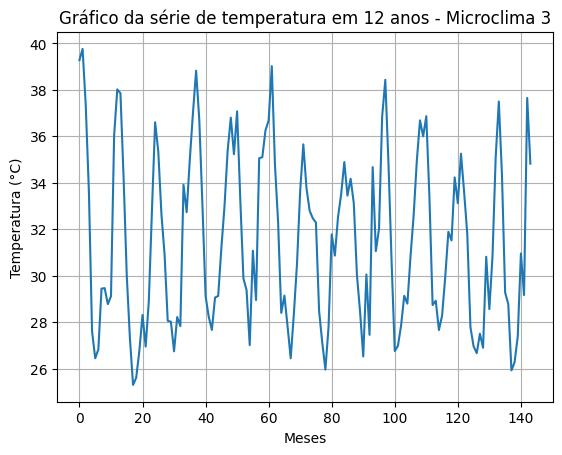

In [157]:
    plt.plot(raw_data.index, raw_data ['value'])
    plt.title ('Gráfico da série de temperatura em 12 anos - Microclima 3')
    plt.ylabel('Temperatura (°C)')
    plt.xlabel('Meses')
    plt.grid()

##### **1.1.2. Resposta**
Analisando o gráfico plotado, não é perceptível uma tendência nesta série, assim a série aparentemente é adequada para a modelagem usando Redes Neurais.
Caso não fosse adequada por apresentar uma tendência, deve-se utilizar técnicas para que a Rede Neural aprenda a tendência da série. Transformações como diferenciação ou outras técnicas de transformação dos dados podem ser aplicadas para estabilizar a variância ou torná-la mais estacionária.

Outra questão observada é que a série apresenta valores ruidosos, o que pode impactar num erro maior na previsão.

A inclusão de variáveis exógenas relevantes pode melhorar a previsão, principalmente se a tendência é influenciada por fatores externos, como, por exemplo, problemas de sazonalidade.

#### **1.2.	Nesta 2ª lista de exercícios, usaremos uma variável exógena que representa o mês de previsão (i.e. no instante t+1). De que forma esta variável pode auxiliar na previsão da série temporal?**

A variável exógena em um modelo de previsão de série temporal pode auxiliar na melhoria das previsões e na captura de relações mais complexas.

Ao incluir variáveis exógenas que têm uma relação significativa com a série temporal, o modelo pode capturar melhor as variações dos dados, assim fazendo previsões mais precisas. Pode ser aplicado em modelos quando há sazonalidade, tendências ou padrões complexos que não conseguem obter uma boa previsão apenas com os valores passados da série temporal.

#### **1.3. Observe que a base de dados não está em um formato adequado para o uso imediato de um modelo de Rede Neural para previsão de séries temporais. Descreva as etapas necessárias de transformação desta base de dados para que possamos utilizá-la no treinamento de uma MLP. Considere que os padrões de entrada (e saída) devem ser normalizados.**

**a) Definição da função 'transform_data'**

*   **'data'** é o conjunto de dados a ser adequado;Item da lista
*   **'lag'** é o tamanho de amostras na janela, sendo o valor padrão igual a 1;
*   **'test_split'** é a proporção de amostras para teste, o valor padrão 0,1 indica que 10% dos dados serão para teste;
*   **'normalize'** indica se os dados serão normalizados, valor padrão True indica que serão normalizados;

*   **'category'** especifica a codificação a ser realizada para a variável exógena (neste caso, o mês). O valor padrão é 'binary'.


    def transform_data(data, lag = 1, test_split = 0.1, normalize = True, category = 'binary'):

**b) Variáveis globais e manipulação dos dados de entrada'**

As variáveis globais são usadas para armazenar os valores de mínimo e máximo dos dados para a normalização.

Os dados de entrada são convertidos para um formato mais fácil de manipular.


    global _min
    global _max


    data_values = data.values

**c) Verifica a proporção dos dados de teste**

*Se a variável 'test_split' está entre 0 ou 1:*

*   1 é o número total de elementos nos dados;
*   Valores de treinamento é do início dos dados até a posição a última posição de treinamento (nº de dados * (1 - test_split);
*   Valores de teste é da última posição de treinamento até o último dado.



*Se a variável 'test_split' é maior que 1:*

*   Valores de treinamento é do início dos dados até a posição test_split;
*   Valores de teste é da posição test_split até o último dado.


*Se não:*


*   Imprime que não entendeu o 'Test split', que deveria ser um número real entre 0 ou 1 ou um inteiro para indexação.



*Verfica se o tamanho do conjunto de teste ('test_values') é pelo menos igual ao 'lag' especificado.*

*O 'lag' é um parâmetro que especifica quantos passos para trás devemos considerar ao criar amostras para previsão.*



    if 0 < test_split < 1.0:
        l = data_values.shape[0]
        train_values = data_values[:-int(test_split*l),0].reshape(-1,1)
        test_values = data_values[-int(test_split*l):,0].reshape(-1,1)
        train_idx = data_values[:-int(test_split*l),1].reshape(-1,1)
        test_idx = data_values[-int(test_split*l):,1].reshape(-1,1)

    elif test_split > 1 and type(test_split) is int:
        train_values = data_values[:-test_split,0].reshape(-1,1)
        test_values = data_values[-test_split:,0].reshape(-1,1)
        train_idx = data_values[:-test_split,1].reshape(-1,1)
        test_idx = data_values[-test_split:,1].reshape(-1,1)

    else:
        print('Test split not understood. Test split should be float between 0 and 1 or integer for index')

    assert test_values.shape[0] >= (lag)

**d) Normalização e preparação dos dados**

*   '_min' e '_max' calculam os valores mínimos e máximos dos dados de treinamento;
*   'if normalize:' normaliza os dados de treinamento e teste;
*   'train_data' e 'test_data' inicializam as matrizes para o armazenamento dos dados de treinamento e teste, com a quantidade de linhas igual ao de amostra e o número de colunas igual ao 'lag' mais 2 (uma coluna para a variável exógena e uma para cada 'lag');
*   'all_data' empilha os arrays de 'train_values' e 'test_values';
*   'all_idx' empilha os arrays dos índices dos valores de treinamento e teste,  'train_idx' e 'test_idx';
*   'new_data' cria uma matriz de zeros com a quantidade de linhas da a ser criada amostra de treinamento e teste, sendo o número de linhas o o total de amostras de treinamento menos o 'lag' mais 1. E o número de colunas sendo o 'lag' mais 2, adicionando uma coluna para a variável exógena e uma para a variável destino.



    _min = np.min(train_values)
    _max = np.max(train_values)

    if normalize:

        test_values = (test_values - _min)/(_max - _min)
        train_values = (train_values - _min)/(_max - _min)

    train_data = np.zeros((train_values.shape[0] - (lag + 1), lag + 2))
    test_data = np.zeros((test_values.shape[0], lag + 2))


    all_data = np.vstack((train_values,test_values))
    all_idx = np.vstack((train_idx,test_idx))

    new_data = np.zeros((train_values.shape[0] - (lag + 1) + test_values.shape[0],lag + 2))


**e) 'new_data' recebe os valores de 'all_data'**

Cada coluna de 'new_data' é preenchida com os valores de 'all_data', começando do índice 'i' até o final do conjunto de dados, considerando o 'lag'+ 1.

    for i in range(lag + 2):
        new_data[:,i] = all_data[i:new_data.shape[0]+i,0]

**f) Codificação da variável exógena**
*Se a variavél categórica for binária:*

*   A variável exógena será representada com 4 dígitos binários, de t0 a t3;
*   Cada dígito de cada representação é armazendo em uma coluna diferente de 't';

*   'temp_idx' contém os rótulos das colunas.



*Se a variavél categórica for '1toN':*

*   Não executa-se nada.



*Se a variável categórica não for binária e nem '1toN':*

*   Os índices 'all_idx' são normalizados e armazenado em 't'
*   O número de colunas de 'temp_idx' é 1, por ter apenas a variável 'month'.

    if category == 'binary':
        binary_rep = [np.binary_repr(z,width=4) for z in all_idx.astype('int').reshape(-1,)]
        t0 = np.array([int(v) for s in binary_rep for v in s[0]])
        t1 = np.array([int(v) for s in binary_rep for v in s[1]])
        t2 = np.array([int(v) for s in binary_rep for v in s[2]])
        t3 = np.array([int(v) for s in binary_rep for v in s[3]])
        t = np.vstack((t0,t1,t2,t3)).T
        t = t[-new_data.shape[0]:,:]
        temp_idx = [f'month_{i}' for i in range(4)]

    elif category == '1toN':
        pass

    else:
        t = (all_idx - np.min(train_idx))/(np.max(train_idx) - np.min(train_idx))
        t = t.reshape(-1,1)
        t = t[-new_data.shape[0]:,:]
        temp_idx = ['month']

**g) Concatenação de 't' com 'new_data'**

A variável exógena codificada 't' é concantenada horizontalmente com a matriz 'new_data'.

    new_data = np.hstack((t,new_data))

**g) Separação dos dados completos de treinamento e teste**

    train_data = new_data[:-test_values.shape[0],:]
    test_data = new_data[-test_values.shape[0]:,:]

**h) Criação e retorno dos DataFrames de treinamento e teste**


*   Cria rótulos de coluna para os DataFrames que serão criados. Os rótulos são baseados no 'lag' e indicam se as colunas representam o valor atual ('y(t)') ou valores anteriores ('y(t-i)' para 'i' variando de -'lag' a 1;
*   Adiciona os rótulos de coluna à lista 'temp_idx;
*   Cria os DataFrames de treinamento e teste;
*   Retorna os DataFrames de treinamento e teste.



    data_columns = [f'y(t{i})' if i < 0 else 'y(t)' if i == 0 else f'y(t+{i})' for i in range(-lag,2)]
    temp_idx.extend(data_columns)
    new_train_df = pd.DataFrame(train_data, columns=temp_idx)
    new_test_df = pd.DataFrame(test_data, columns=temp_idx)

    return new_train_df, new_test_df

## **Parte 2 - Previsão one-step**

Total: 2,0 pts

<b> IMPORTANTE! </b> Este processo não é a previsão multi-step, conforme ensinado em sala de aula.
Esta parte da lista é importante para evitar erros de avaliação para a previsão de séries temporais com um horizonte de previsão maior que 1.

#### **2.1.	Execute o script para a previsão one-step. Avalie o resultado (conjunto de treinamento e teste) usando métricas apropriadas, como RMSE e MAE.**

##### **2.1.1.	Rascunho**

In [158]:
prev = 12
train_val ,test_val = transform_data(raw_data,lag=12,test_split = prev,normalize=True,category='binary')

In [159]:
train_val

,month_0,month_1,month_2,month_3,y(t-12),y(t-11),y(t-10),y(t-9),y(t-8),y(t-7),y(t-6),y(t-5),y(t-4),y(t-3),y(t-2),y(t-1),y(t),y(t+1)
0,0.0,0.0,1.0,0.0,0.966754,1.000000,0.831228,0.574628,0.159623,0.079324,0.105737,0.286608,0.288055,0.240466,0.263754,0.742800,0.879664,0.868229
1,0.0,0.0,1.0,1.0,1.000000,0.831228,0.574628,0.159623,0.079324,0.105737,0.286608,0.288055,0.240466,0.263754,0.742800,0.879664,0.868229,0.617472
2,0.0,1.0,0.0,0.0,0.831228,0.574628,0.159623,0.079324,0.105737,0.286608,0.288055,0.240466,0.263754,0.742800,0.879664,0.868229,0.617472,0.326416
3,0.0,1.0,0.0,1.0,0.574628,0.159623,0.079324,0.105737,0.286608,0.288055,0.240466,0.263754,0.742800,0.879664,0.868229,0.617472,0.326416,0.139643
4,0.0,1.0,1.0,0.0,0.159623,0.079324,0.105737,0.286608,0.288055,0.240466,0.263754,0.742800,0.879664,0.868229,0.617472,0.326416,0.139643,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,1.0,0.0,0.0,0.0,0.163287,0.206051,0.320193,0.455912,0.430008,0.617567,0.540707,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517
115,1.0,0.0,0.0,1.0,0.206051,0.320193,0.455912,0.430008,0.617567,0.540707,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638
116,1.0,0.0,1.0,0.0,0.320193,0.455912,0.430008,0.617567,0.540707,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441
117,1.0,0.0,1.0,1.0,0.455912,0.430008,0.617567,0.540707,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590


In [160]:
test_val

,month_0,month_1,month_2,month_3,y(t-12),y(t-11),y(t-10),y(t-9),y(t-8),y(t-7),y(t-6),y(t-5),y(t-4),y(t-3),y(t-2),y(t-1),y(t),y(t+1)
0,0.0,0.0,0.0,1.0,0.617567,0.540707,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615
1,0.0,0.0,1.0,0.0,0.540707,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498
2,0.0,0.0,1.0,1.0,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367
3,0.0,1.0,0.0,0.0,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147
4,0.0,1.0,0.0,1.0,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147,0.240339
5,0.0,1.0,1.0,0.0,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147,0.240339,0.043136
6,0.0,1.0,1.0,1.0,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147,0.240339,0.043136,0.067530
7,1.0,0.0,0.0,0.0,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147,0.240339,0.043136,0.067530,0.144327
8,1.0,0.0,0.0,1.0,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147,0.240339,0.043136,0.067530,0.144327,0.391317
9,1.0,0.0,1.0,0.0,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147,0.240339,0.043136,0.067530,0.144327,0.391317,0.267489


In [161]:
train_values = train_val.values

X_train = train_values[:,:-1]
y_train = train_values[:,-1]

test_values = test_val.values
X_test = test_values[:,:-1]
y_test = test_values[:,-1]

In [162]:
train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))

test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))

In [163]:
batch_size = 32

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)

test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [164]:
n_input = X_train.shape[1]
n_output = 1
hidden_neurons = 20

In [165]:
model = NeuralNetwork(n_input = n_input, n_output=n_output, hidden_neurons = hidden_neurons, hidden_activation='sigmoid')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

lr = 0.05
epochs = 1000

history, y_hat = train(model, train_loader, epochs, device, lr)

 10%|▉         | 95/1000 [00:00<00:03, 239.77it/s]

Epoch 51/1000, Loss: 0.0260
Epoch 101/1000, Loss: 0.0152


 20%|█▉        | 196/1000 [00:00<00:03, 244.70it/s]

Epoch 151/1000, Loss: 0.0123


 25%|██▍       | 248/1000 [00:01<00:03, 249.74it/s]

Epoch 201/1000, Loss: 0.0117
Epoch 251/1000, Loss: 0.0115


 33%|███▎      | 327/1000 [00:01<00:02, 248.02it/s]

Epoch 301/1000, Loss: 0.0113


 38%|███▊      | 378/1000 [00:01<00:02, 240.98it/s]

Epoch 351/1000, Loss: 0.0111


 43%|████▎     | 429/1000 [00:01<00:02, 245.05it/s]

Epoch 401/1000, Loss: 0.0109


 48%|████▊     | 481/1000 [00:01<00:02, 248.15it/s]

Epoch 451/1000, Loss: 0.0108
Epoch 501/1000, Loss: 0.0106


 58%|█████▊    | 584/1000 [00:02<00:01, 252.57it/s]

Epoch 551/1000, Loss: 0.0105
Epoch 601/1000, Loss: 0.0104


 68%|██████▊   | 684/1000 [00:02<00:01, 239.13it/s]

Epoch 651/1000, Loss: 0.0103


 73%|███████▎  | 732/1000 [00:03<00:01, 233.21it/s]

Epoch 701/1000, Loss: 0.0102


 78%|███████▊  | 785/1000 [00:03<00:00, 245.98it/s]

Epoch 751/1000, Loss: 0.0101
Epoch 801/1000, Loss: 0.0100


 89%|████████▉ | 888/1000 [00:03<00:00, 253.04it/s]

Epoch 851/1000, Loss: 0.0099
Epoch 901/1000, Loss: 0.0098


100%|██████████| 1000/1000 [00:04<00:00, 244.27it/s]

Epoch 951/1000, Loss: 0.0098
Epoch 1001/1000, Loss: 0.0097


In [166]:
y_pred = model(torch.from_numpy(X_test).float())
y_hat = y_pred.detach().numpy()


Erro MSE = 6.735 
Erro MAE = 1.891


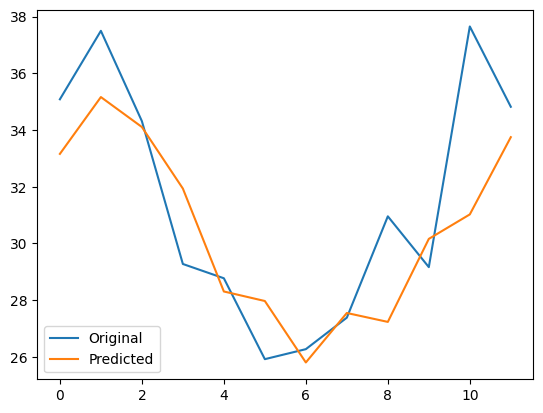

In [167]:
orig_y_eval = y_test*(_max-_min) + _min
orig_y_hat = y_hat*(_max-_min) + _min
mae_error = mean_absolute_error(orig_y_eval, orig_y_hat)
mse_error = mean_squared_error(orig_y_eval, orig_y_hat)

plt.plot(orig_y_eval)
plt.plot(orig_y_hat)
plt.legend(['Original','Predicted'])

print(f'Erro MSE = {round(mse_error,3)} \nErro MAE = {round(mae_error,3)}')


In [168]:
media = raw_data ['value'].mean()
print (media)

31.477578080268074


In [169]:
erro_MAE_por_media = mae_error/media
print (erro_MAE_por_media)

0.06006507420647009


##### **2.1.2.	Resposta**

**Rodada 1:**

Erro MSE = **6.74** (°C)²

Erro MAE = **1.89** °C



**Rodada 2:**

Erro MSE = **6.78** (°C)²

Erro MAE = **1.89** °C



**Rodada 3:**

Erro MSE = **6.51** (°C)²

Erro MAE = **1.85** °C

O Mean Squared Error (MSE) mede a média dos quadrados das diferenças entre os valores reais e os valores previstos. Como eleva os erros ao quadrado, o MSE penaliza mais os grandes erros. Assim, sendo mais sensível a *outliers* por amplificar os grandes desvios. Já a unidade de saída do MSE dificulta a interpretação por ser elevado ao quadrado, nesse caso é (°C), não possuindo um significado físico. O MSE igual a **6,74** mostra que há grandes diferenças na previsão, como pode-se observar nos valores reais dos picos, da parte superior do gráfico, acima dos valores previstos. Desta forma, infere-se que a série apresenta valores ruidosos que impactam nos resultado da predição.

Já o Mean Absolute Error (MAE) mede a média das diferenças absolutas entre os valores reais e os valores previstos, sendo uma métrica direta da precisão do modelo, tendo a mesma unidade dos dados, facilitando a interpretação, nesse caso a unidade de MAE é °C, possuindo um significado físico. Por outro lado, comoarando com o MSE é menos sensível a *outliers*, pois não amplifica ao quadrado o erro. Nesta análise o erro MAE é de **1,89** °C, em percentual da média dos valores de temperaturas de toda série, é de **6,0%**. Dependendo do problema a ser aplicado a previsão desta série, pode ser um erro considerável. Este erro pode ser ocasionado pela série ruidosa.

#### **2.2.	Modifique a técnica de codificação mensal de ‘binário’ para ‘numérico’. Qual a mudança existente na arquitetura da Rede Neural? Analise o resultado (conjunto de treinamento e teste), usando as métricas adequadas.**

##### **2.2.1.	Rascunho**

In [170]:
prev = 12
train_val ,test_val = transform_data(raw_data,lag=12,test_split = prev,normalize=True,category='numeric')



In [171]:
train_val

,month,y(t-12),y(t-11),y(t-10),y(t-9),y(t-8),y(t-7),y(t-6),y(t-5),y(t-4),y(t-3),y(t-2),y(t-1),y(t),y(t+1)
0,0.090909,0.966754,1.000000,0.831228,0.574628,0.159623,0.079324,0.105737,0.286608,0.288055,0.240466,0.263754,0.742800,0.879664,0.868229
1,0.181818,1.000000,0.831228,0.574628,0.159623,0.079324,0.105737,0.286608,0.288055,0.240466,0.263754,0.742800,0.879664,0.868229,0.617472
2,0.272727,0.831228,0.574628,0.159623,0.079324,0.105737,0.286608,0.288055,0.240466,0.263754,0.742800,0.879664,0.868229,0.617472,0.326416
3,0.363636,0.574628,0.159623,0.079324,0.105737,0.286608,0.288055,0.240466,0.263754,0.742800,0.879664,0.868229,0.617472,0.326416,0.139643
4,0.454545,0.159623,0.079324,0.105737,0.286608,0.288055,0.240466,0.263754,0.742800,0.879664,0.868229,0.617472,0.326416,0.139643,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,0.636364,0.163287,0.206051,0.320193,0.455912,0.430008,0.617567,0.540707,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517
115,0.727273,0.206051,0.320193,0.455912,0.430008,0.617567,0.540707,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638
116,0.818182,0.320193,0.455912,0.430008,0.617567,0.540707,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441
117,0.909091,0.455912,0.430008,0.617567,0.540707,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590


In [172]:
test_val

,month,y(t-12),y(t-11),y(t-10),y(t-9),y(t-8),y(t-7),y(t-6),y(t-5),y(t-4),y(t-3),y(t-2),y(t-1),y(t),y(t+1)
0,0.000000,0.617567,0.540707,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615
1,0.090909,0.540707,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498
2,0.181818,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367
3,0.272727,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147
4,0.363636,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147,0.240339
5,0.454545,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147,0.240339,0.043136
6,0.545455,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147,0.240339,0.043136,0.067530
7,0.636364,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147,0.240339,0.043136,0.067530,0.144327
8,0.727273,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147,0.240339,0.043136,0.067530,0.144327,0.391317
9,0.818182,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147,0.240339,0.043136,0.067530,0.144327,0.391317,0.267489


In [173]:
train_values = train_val.values

X_train = train_values[:,:-1]
y_train = train_values[:,-1]

test_values = test_val.values
X_test = test_values[:,:-1]
y_test = test_values[:,-1]

In [174]:
train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))

test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))

In [175]:
batch_size = 32

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)

test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [176]:
n_input = X_train.shape[1]
n_output = 1
hidden_neurons = 20

In [177]:
model = NeuralNetwork(n_input = n_input, n_output=n_output, hidden_neurons = hidden_neurons, hidden_activation='sigmoid')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

lr = 0.05
epochs = 1000

history, y_hat = train(model, train_loader, epochs, device, lr)

  7%|▋         | 73/1000 [00:00<00:05, 178.12it/s]

Epoch 51/1000, Loss: 0.0342


 13%|█▎        | 129/1000 [00:00<00:04, 179.56it/s]

Epoch 101/1000, Loss: 0.0212


 18%|█▊        | 184/1000 [00:01<00:04, 178.73it/s]

Epoch 151/1000, Loss: 0.0149


 22%|██▏       | 220/1000 [00:01<00:04, 171.22it/s]

Epoch 201/1000, Loss: 0.0135


 28%|██▊       | 276/1000 [00:01<00:04, 176.93it/s]

Epoch 251/1000, Loss: 0.0133


 33%|███▎      | 328/1000 [00:01<00:04, 161.15it/s]

Epoch 301/1000, Loss: 0.0133


 38%|███▊      | 381/1000 [00:02<00:03, 169.57it/s]

Epoch 351/1000, Loss: 0.0133


 44%|████▎     | 435/1000 [00:02<00:03, 168.86it/s]

Epoch 401/1000, Loss: 0.0132


 47%|████▋     | 471/1000 [00:02<00:03, 171.75it/s]

Epoch 451/1000, Loss: 0.0131


 53%|█████▎    | 532/1000 [00:03<00:02, 189.96it/s]

Epoch 501/1000, Loss: 0.0130


 58%|█████▊    | 583/1000 [00:03<00:01, 220.77it/s]

Epoch 551/1000, Loss: 0.0129


 63%|██████▎   | 632/1000 [00:03<00:01, 232.34it/s]

Epoch 601/1000, Loss: 0.0128
Epoch 651/1000, Loss: 0.0127


 74%|███████▎  | 735/1000 [00:03<00:01, 248.26it/s]

Epoch 701/1000, Loss: 0.0126
Epoch 751/1000, Loss: 0.0126


 84%|████████▍ | 839/1000 [00:04<00:00, 253.98it/s]

Epoch 801/1000, Loss: 0.0125
Epoch 851/1000, Loss: 0.0124


 95%|█████████▍| 946/1000 [00:04<00:00, 258.54it/s]

Epoch 901/1000, Loss: 0.0124
Epoch 951/1000, Loss: 0.0123


100%|██████████| 1000/1000 [00:04<00:00, 201.57it/s]

Epoch 1001/1000, Loss: 0.0122


In [178]:
y_pred = model(torch.from_numpy(X_test).float())
y_hat = y_pred.detach().numpy()


Erro MSE = 6.434 
Erro MAE = 1.73


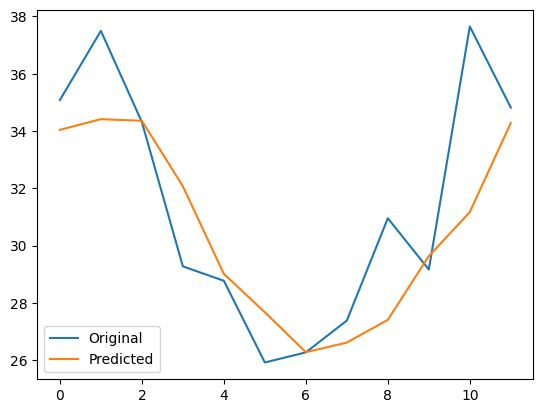

In [179]:
orig_y_eval = y_test*(_max-_min) + _min
orig_y_hat = y_hat*(_max-_min) + _min
mae_error = mean_absolute_error(orig_y_eval, orig_y_hat)
mse_error = mean_squared_error(orig_y_eval, orig_y_hat)

plt.plot(orig_y_eval)
plt.plot(orig_y_hat)
plt.legend(['Original','Predicted'])

print(f'Erro MSE = {round(mse_error,3)} \nErro MAE = {round(mae_error,3)}')


##### **2.2.2.	Resposta**

Modificando a técnica de codificação mensal da variável exógena de 'binária' para 'numérica' os erros obtidos foram:


**Rodada 1:**

Erro MSE = **6.43** (°C)²

Erro MAE = **1.73** °C



**Rodada 2:**

Erro MSE = **6.08** (°C)²

Erro MAE = **1.79** °C



**Rodada 3:**

Erro MSE = **6.23** (°C)²

Erro MAE = **1.83** °C

Assim, nota-se que não há uma grande variação dos erros desta análise com a codificação da variável exógena 'numérica', em comparação com o item 2.1 com 'binária' apresenta erros MSE e MAE ligeiramente menor, então ambas as categorias para a variável exógena prevem séries de maneira similar. No caso binário, os meses foram codificadas pelas 4 variáveis, t0 a t3. Os resultados da análise numérica tiveram um desempenho um pouco melhor que a primeira, pois os meses podem ser modeladas como uma variável contínua, como pode se ver na variável 'month', cujo intervalo entre meses é de 0,0909.

Comparando os gráficos de valores reais e preditos para a codificação 'binária' e 'numérica', nota-se que na primeira o gráfico dos valores preditos ficou com mais "picos", já o da 'numérica' apresenta-se mais suave por ser representado com uma codificação de variável contínua.

## **Parte 3 - Previsão multi-step**

Total: 5,0 pts.

#### **3.1.	Esquematize como você implementaria o processo de previsão multi-step. Descreva todos os passos necessários, e em seguida compare com o código fornecido para a previsão.**

##### **3.1.1.	Rascunho**

In [180]:
def multi_step(model, X_test, cod='numeric'):
  y_result = []
  X_t = np.copy(X_test[0])
  for i in range(prev):
      y_hat = model(torch.from_numpy(X_t).float())

      if cod == 'numeric':

        #Ajeitando a codificação. Transformamos para o valor do mês e somamos 1 (para o próximo passo) e
        #depois pegamos o resto da divisão por 12 (para que o mês fique sempre entre 0 e 11)
        tmp = int(X_t[0] * 12 + 1) % 12

        #Alterando a variável mês
        X_t[0] = tmp/12

        #Movendo todos os registros, 'deslizando a janela'
        X_t[1:X_t.shape[0]-1] = X_t[2:]

      elif cod == 'binary':
        pass

      else:
        print('Erro de codificação.')
        break


      X_t[-1] = y_hat

      y_result.append(y_hat[0].detach().numpy())


  return np.array(y_result)

##### **3.1.2.	Resposta**

###### **a) Definição da função e inicialização**

*   Define a função **'multi_step'** que recebe o modelo **'model'**, os dados de teste **'X_test'** e o tipo de codificação **'cod'**, sendo default 'numeric';
*   Inicializa uma lista, **'y_result'**, para armazenar as previsões;
*   Faz uma cópia da primeira amostra de **'X_test'** para iniciar a previsão.

    def multi_step(model, X_test, cod='numeric'):
      y_result = []
      X_t = np.copy(X_test[0])

###### **b) Previsão Multi-step**

*   Itera sobre o número de passos à frente;
*   Converte **'X_t'** para um tensor PyTorch e faz a previsão usando o modelo;

      for i in range(prev):
          y_hat = model(torch.from_numpy(X_t).float())

###### **c) Codificação numérica**
Se a codificação é **'numeric'**:
*   Calcula o valor do próximo mês **'tmp'**;
*   Normaliza o **'tmp'** para um intervalo entre 0 e 1;
*   Move todos os registros para uma posição a frente, deslizando a janela.

          if cod == 'numeric':

            #Ajeitando a codificação. Transformamos para o valor do mês e somamos 1 (para o próximo passo) e
            #depois pegamos o resto da divisão por 12 (para que o mês fique sempre entre 0 e 11)
            tmp = int(X_t[0] * 12 + 1) % 12

            #Alterando a variável mês
            X_t[0] = tmp/12

            #Movendo todos os registros, 'deslizando a janela'
            X_t[1:X_t.shape[0]-1] = X_t[2:]

###### **d) Codificação binária**

*   Não executa-se nada.

          elif cod == 'binary':
            pass

###### **e) Erro de codificação**
Se **'cod'** não é **'numeric'** e nem **'binary'**:
*   Imprime a mensagem de erro, **'Erro de codificação'**;
*   Interrompe o loop.


          else:
            print('Erro de codificação.')
            break

###### **f) Atualização e armazenamento**
*   Atualiza a entrada mais recente com a última previsão;
*   Armazena a última previsão na lista **'y_result'**.


          X_t[-1] = y_hat

          y_result.append(y_hat[0].detach().numpy())

###### **g) Retorno das previsões**
*   Retorna as previsões como um array.


      return np.array(y_result)

#### **3.2.	Faça a previsão multi-step para o horizonte de previsão igual a 12. Perceba que o resultado da métrica é, geralmente, pior do que o apresentado para a previsão one-step. Por quê? É justo comparar o resultado deste item com o que foi apresentado anteriormente? Discuta.**

##### **3.2.1.	Rascunho**

In [181]:
y_result = multi_step(model, X_test, cod='numeric')

Erro MSE = 8.48 
Erro MAE = 2.193


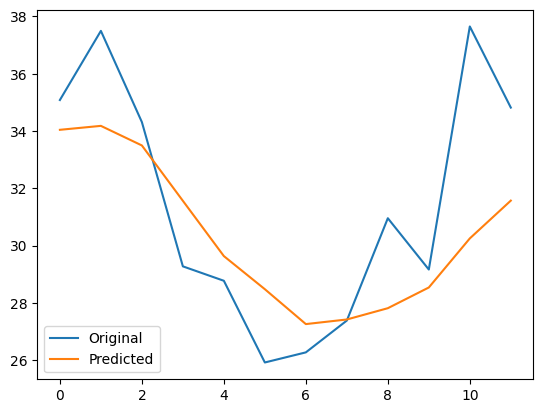

In [182]:
orig_y_eval = y_test*(_max-_min) + _min
orig_y_hat = y_result*(_max-_min) + _min
mae_error = mean_absolute_error(orig_y_eval, orig_y_hat)
mse_error = mean_squared_error(orig_y_eval, orig_y_hat)

plt.plot(orig_y_eval)
plt.plot(orig_y_hat)
plt.legend(['Original','Predicted'])

print(f'Erro MSE = {round(mse_error,3)} \nErro MAE = {round(mae_error,3)}')

##### **3.2.2.	Resposta**

**RESULTADO DA ANÁLISE ONE-STEP**

**Rodada 1:**

Erro MSE = **6.43** (°C)²

Erro MAE = **1.73** °C

**Rodada 2:**

Erro MSE = **6.08** (°C)²

Erro MAE = **1.79** °C

**Rodada 3:**

Erro MSE = **6.23** (°C)²

Erro MAE = **1.83** °C

**RESULTADO DA ANÁLISE MULTI-STEP**

**Rodada 1:**

Erro MSE = **8.48** (°C)²

Erro MAE = **2.19** °C

**Rodada 2:**

Erro MSE = **8.52** (°C)²

Erro MAE = **2.20** °C

**Rodada 3:**

Erro MSE = **8.56** (°C)²

Erro MAE = **2.21** °C

O resultado da análise multi-step é pior, pois na análise one-step a previsão é feita apenas para o próximo passo, usando os dados mais recentes como entrada, assim limitando o acúmulo de erros. Já a multi-step faz previsões passos à frente e a previsão seguinte usa como entrada os valores previstos anteriormente, assim podendo acumular erros progressivamente.
Portanto, não é justo comparar os resultados da análise one-step com a multi-step, pela segunda apresentar os erros MSE e MAE mais elevados, devido à propagação dos erros.

#### **3.3.	Modifique o tamanho da janela de entrada do modelo. Analise os resultados, utilizando as métricas adequadas.**

##### **3.3.1.	Rascunho**

In [183]:
lag_list = [2,6,12,18,24,48,70]
mae_error_list = []
mse_error_list = []
n_output = 1
hidden_neurons = 20
lr = 0.05
epochs = 1000


for lag in lag_list:
    if lag > 12:
        prev = lag
    else:
        prev = 12
    train_val ,test_val = transform_data(raw_data,lag=lag,test_split = prev,normalize=True,category='numeric')

    print("\n \nTamanho da janela %i" %lag)
    print (train_val)
    print (test_val)

    train_values = train_val.values

    X_train = train_values[:,:-1]
    y_train = train_values[:,-1]

    test_values = test_val.values
    X_test = test_values[:,:-1]
    y_test = test_values[:,-1]

    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))

    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))

    batch_size = 32

    train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)

    test_loader = DataLoader(dataset=test_dataset, batch_size=1)

    n_input = X_train.shape[1]

    model = NeuralNetwork(n_input = n_input, n_output=n_output, hidden_neurons = hidden_neurons, hidden_activation='sigmoid')
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


    history, y_hat = train(model, train_loader, epochs, device, lr)
    print("")

    y_result = multi_step(model, X_test, cod='numeric')

    orig_y_eval = y_test*(_max-_min) + _min
    orig_y_hat = y_result*(_max-_min) + _min

    mae_error = mean_absolute_error(orig_y_eval, orig_y_hat)
    mse_error = mean_squared_error(orig_y_eval, orig_y_hat)

    # plt.plot(orig_y_eval)
    # plt.plot(orig_y_hat)
    # plt.legend(['Original','Predicted'])

    print(f'Erro MSE = {round(mse_error,3)} \nErro MAE = {round(mae_error,3)}')

    mae_error_list.append(round(mae_error, 2))
    mse_error_list.append(round(mse_error, 2))

# Resultado dos erros para o tamanho da janela
print("\n \nTamanho da janela", lag_list)
print("MSE erros:", mse_error_list)
print("MAE erros:", mae_error_list)


 
Tamanho da janela 2
        month    y(t-2)    y(t-1)      y(t)    y(t+1)
0    0.272727  0.966754  1.000000  0.831228  0.574628
1    0.363636  1.000000  0.831228  0.574628  0.159623
2    0.454545  0.831228  0.574628  0.159623  0.079324
3    0.545455  0.574628  0.159623  0.079324  0.105737
4    0.636364  0.159623  0.079324  0.105737  0.286608
..        ...       ...       ...       ...       ...
124  0.636364  0.171795  0.114689  0.094584  0.152517
125  0.727273  0.114689  0.094584  0.152517  0.110638
126  0.818182  0.094584  0.152517  0.110638  0.381441
127  0.909091  0.152517  0.110638  0.381441  0.225590
128  1.000000  0.110638  0.381441  0.225590  0.384723

[129 rows x 5 columns]
       month    y(t-2)    y(t-1)      y(t)    y(t+1)
0   0.000000  0.381441  0.225590  0.384723  0.676615
1   0.090909  0.225590  0.384723  0.676615  0.843498
2   0.181818  0.384723  0.676615  0.843498  0.623367
3   0.272727  0.676615  0.843498  0.623367  0.275147
4   0.363636  0.843498  0.623367  0.2751

  7%|▋         | 69/1000 [00:00<00:04, 211.52it/s]

Epoch 51/1000, Loss: 0.0016


 14%|█▎        | 136/1000 [00:00<00:04, 212.07it/s]

Epoch 101/1000, Loss: 0.0031


 18%|█▊        | 181/1000 [00:00<00:03, 216.21it/s]

Epoch 151/1000, Loss: 0.0041


 22%|██▎       | 225/1000 [00:01<00:03, 209.29it/s]

Epoch 201/1000, Loss: 0.0043


 29%|██▉       | 292/1000 [00:01<00:03, 214.57it/s]

Epoch 251/1000, Loss: 0.0038


 34%|███▎      | 335/1000 [00:01<00:03, 203.82it/s]

Epoch 301/1000, Loss: 0.0030


 38%|███▊      | 378/1000 [00:01<00:02, 207.55it/s]

Epoch 351/1000, Loss: 0.0022


 42%|████▏     | 420/1000 [00:02<00:02, 195.37it/s]

Epoch 401/1000, Loss: 0.0015


 48%|████▊     | 485/1000 [00:02<00:02, 195.04it/s]

Epoch 451/1000, Loss: 0.0011


 53%|█████▎    | 528/1000 [00:02<00:02, 203.56it/s]

Epoch 501/1000, Loss: 0.0008


 57%|█████▋    | 573/1000 [00:02<00:02, 212.74it/s]

Epoch 551/1000, Loss: 0.0005


 64%|██████▎   | 637/1000 [00:03<00:01, 205.83it/s]

Epoch 601/1000, Loss: 0.0004


 68%|██████▊   | 680/1000 [00:03<00:01, 206.32it/s]

Epoch 651/1000, Loss: 0.0003


 72%|███████▏  | 723/1000 [00:03<00:01, 205.36it/s]

Epoch 701/1000, Loss: 0.0002


 79%|███████▉  | 789/1000 [00:03<00:01, 209.39it/s]

Epoch 751/1000, Loss: 0.0002


 83%|████████▎ | 831/1000 [00:04<00:00, 200.76it/s]

Epoch 801/1000, Loss: 0.0002


 87%|████████▋ | 874/1000 [00:04<00:00, 205.83it/s]

Epoch 851/1000, Loss: 0.0001


 94%|█████████▍| 940/1000 [00:04<00:00, 213.33it/s]

Epoch 901/1000, Loss: 0.0001


 98%|█████████▊| 985/1000 [00:04<00:00, 216.77it/s]

Epoch 951/1000, Loss: 0.0001


100%|██████████| 1000/1000 [00:04<00:00, 207.25it/s]


Epoch 1001/1000, Loss: 0.0001

Erro MSE = 16.763 
Erro MAE = 3.68

 
Tamanho da janela 6
        month    y(t-6)    y(t-5)    y(t-4)    y(t-3)    y(t-2)    y(t-1)  \
0    0.636364  0.966754  1.000000  0.831228  0.574628  0.159623  0.079324   
1    0.727273  1.000000  0.831228  0.574628  0.159623  0.079324  0.105737   
2    0.818182  0.831228  0.574628  0.159623  0.079324  0.105737  0.286608   
3    0.909091  0.574628  0.159623  0.079324  0.105737  0.286608  0.288055   
4    1.000000  0.159623  0.079324  0.105737  0.286608  0.288055  0.240466   
..        ...       ...       ...       ...       ...       ...       ...   
120  0.636364  0.540707  0.688145  0.573369  0.448349  0.171795  0.114689   
121  0.727273  0.688145  0.573369  0.448349  0.171795  0.114689  0.094584   
122  0.818182  0.573369  0.448349  0.171795  0.114689  0.094584  0.152517   
123  0.909091  0.448349  0.171795  0.114689  0.094584  0.152517  0.110638   
124  1.000000  0.171795  0.114689  0.094584  0.152517  0.110638 

  8%|▊         | 77/1000 [00:00<00:03, 250.70it/s]

Epoch 51/1000, Loss: 0.0336


 13%|█▎        | 128/1000 [00:00<00:03, 229.95it/s]

Epoch 101/1000, Loss: 0.0231


 18%|█▊        | 179/1000 [00:00<00:03, 242.01it/s]

Epoch 151/1000, Loss: 0.0168
Epoch 201/1000, Loss: 0.0141


 28%|██▊       | 284/1000 [00:01<00:02, 252.34it/s]

Epoch 251/1000, Loss: 0.0132


 34%|███▎      | 336/1000 [00:01<00:02, 250.03it/s]

Epoch 301/1000, Loss: 0.0128
Epoch 351/1000, Loss: 0.0126


 44%|████▍     | 440/1000 [00:01<00:02, 251.86it/s]

Epoch 401/1000, Loss: 0.0124
Epoch 451/1000, Loss: 0.0123


 55%|█████▍    | 545/1000 [00:02<00:01, 248.72it/s]

Epoch 501/1000, Loss: 0.0121
Epoch 551/1000, Loss: 0.0120


 62%|██████▏   | 623/1000 [00:02<00:01, 250.63it/s]

Epoch 601/1000, Loss: 0.0119


 67%|██████▋   | 673/1000 [00:02<00:01, 209.75it/s]

Epoch 651/1000, Loss: 0.0118


 74%|███████▎  | 736/1000 [00:03<00:01, 188.23it/s]

Epoch 701/1000, Loss: 0.0117


 77%|███████▋  | 774/1000 [00:03<00:01, 179.18it/s]

Epoch 751/1000, Loss: 0.0116


 83%|████████▎ | 830/1000 [00:03<00:00, 178.86it/s]

Epoch 801/1000, Loss: 0.0115


 89%|████████▊ | 886/1000 [00:04<00:00, 181.43it/s]

Epoch 851/1000, Loss: 0.0114


 92%|█████████▏| 923/1000 [00:04<00:00, 169.81it/s]

Epoch 901/1000, Loss: 0.0113


 98%|█████████▊| 976/1000 [00:04<00:00, 166.65it/s]

Epoch 951/1000, Loss: 0.0113


100%|██████████| 1000/1000 [00:04<00:00, 212.34it/s]


Epoch 1001/1000, Loss: 0.0112

Erro MSE = 14.71 
Erro MAE = 3.174

 
Tamanho da janela 12
        month   y(t-12)   y(t-11)   y(t-10)    y(t-9)    y(t-8)    y(t-7)  \
0    0.090909  0.966754  1.000000  0.831228  0.574628  0.159623  0.079324   
1    0.181818  1.000000  0.831228  0.574628  0.159623  0.079324  0.105737   
2    0.272727  0.831228  0.574628  0.159623  0.079324  0.105737  0.286608   
3    0.363636  0.574628  0.159623  0.079324  0.105737  0.286608  0.288055   
4    0.454545  0.159623  0.079324  0.105737  0.286608  0.288055  0.240466   
..        ...       ...       ...       ...       ...       ...       ...   
114  0.636364  0.163287  0.206051  0.320193  0.455912  0.430008  0.617567   
115  0.727273  0.206051  0.320193  0.455912  0.430008  0.617567  0.540707   
116  0.818182  0.320193  0.455912  0.430008  0.617567  0.540707  0.688145   
117  0.909091  0.455912  0.430008  0.617567  0.540707  0.688145  0.573369   
118  1.000000  0.430008  0.617567  0.540707  0.688145  0.573369

  7%|▋         | 70/1000 [00:00<00:05, 157.36it/s]

Epoch 51/1000, Loss: 0.0302


 12%|█▏        | 118/1000 [00:00<00:05, 157.35it/s]

Epoch 101/1000, Loss: 0.0184


 20%|█▉        | 196/1000 [00:01<00:03, 225.20it/s]

Epoch 151/1000, Loss: 0.0143
Epoch 201/1000, Loss: 0.0136


 30%|███       | 301/1000 [00:01<00:02, 250.48it/s]

Epoch 251/1000, Loss: 0.0135
Epoch 301/1000, Loss: 0.0134


 38%|███▊      | 379/1000 [00:01<00:02, 249.81it/s]

Epoch 351/1000, Loss: 0.0132


 43%|████▎     | 430/1000 [00:02<00:02, 229.34it/s]

Epoch 401/1000, Loss: 0.0131


 48%|████▊     | 481/1000 [00:02<00:02, 234.66it/s]

Epoch 451/1000, Loss: 0.0129
Epoch 501/1000, Loss: 0.0128


 58%|█████▊    | 582/1000 [00:02<00:01, 242.30it/s]

Epoch 551/1000, Loss: 0.0127


 63%|██████▎   | 633/1000 [00:02<00:01, 246.22it/s]

Epoch 601/1000, Loss: 0.0126
Epoch 651/1000, Loss: 0.0124


 74%|███████▍  | 738/1000 [00:03<00:01, 255.73it/s]

Epoch 701/1000, Loss: 0.0123
Epoch 751/1000, Loss: 0.0123


 84%|████████▍ | 843/1000 [00:03<00:00, 240.06it/s]

Epoch 801/1000, Loss: 0.0122


 89%|████████▉ | 894/1000 [00:03<00:00, 243.22it/s]

Epoch 851/1000, Loss: 0.0121


 94%|█████████▍| 945/1000 [00:04<00:00, 247.68it/s]

Epoch 901/1000, Loss: 0.0120
Epoch 951/1000, Loss: 0.0120


100%|██████████| 1000/1000 [00:04<00:00, 231.84it/s]


Epoch 1001/1000, Loss: 0.0119

Erro MSE = 8.729 
Erro MAE = 2.232

 
Tamanho da janela 18
        month   y(t-18)   y(t-17)   y(t-16)   y(t-15)   y(t-14)   y(t-13)  \
0    0.636364  0.966754  1.000000  0.831228  0.574628  0.159623  0.079324   
1    0.727273  1.000000  0.831228  0.574628  0.159623  0.079324  0.105737   
2    0.818182  0.831228  0.574628  0.159623  0.079324  0.105737  0.286608   
3    0.909091  0.574628  0.159623  0.079324  0.105737  0.286608  0.288055   
4    1.000000  0.159623  0.079324  0.105737  0.286608  0.288055  0.240466   
..        ...       ...       ...       ...       ...       ...       ...   
102  0.090909  0.176543  0.265194  0.241988  0.383226  0.506170  0.668011   
103  0.181818  0.265194  0.241988  0.383226  0.506170  0.668011  0.787349   
104  0.272727  0.241988  0.383226  0.506170  0.668011  0.787349  0.739774   
105  0.363636  0.383226  0.506170  0.668011  0.787349  0.739774  0.799904   
106  0.454545  0.506170  0.668011  0.787349  0.739774  0.799904

  8%|▊         | 81/1000 [00:00<00:03, 251.14it/s]

Epoch 51/1000, Loss: 0.0210
Epoch 101/1000, Loss: 0.0111


 19%|█▊        | 187/1000 [00:00<00:03, 255.22it/s]

Epoch 151/1000, Loss: 0.0085
Epoch 201/1000, Loss: 0.0086


 29%|██▉       | 289/1000 [00:01<00:02, 241.20it/s]

Epoch 251/1000, Loss: 0.0087


 34%|███▍      | 339/1000 [00:01<00:02, 238.44it/s]

Epoch 301/1000, Loss: 0.0086


 39%|███▉      | 389/1000 [00:01<00:02, 243.35it/s]

Epoch 351/1000, Loss: 0.0084
Epoch 401/1000, Loss: 0.0083


 50%|████▉     | 496/1000 [00:01<00:01, 258.41it/s]

Epoch 451/1000, Loss: 0.0081
Epoch 501/1000, Loss: 0.0079


 58%|█████▊    | 576/1000 [00:02<00:01, 258.83it/s]

Epoch 551/1000, Loss: 0.0078
Epoch 601/1000, Loss: 0.0076


 68%|██████▊   | 677/1000 [00:02<00:01, 224.73it/s]

Epoch 651/1000, Loss: 0.0075


 72%|███████▏  | 723/1000 [00:02<00:01, 222.06it/s]

Epoch 701/1000, Loss: 0.0074


 78%|███████▊  | 777/1000 [00:03<00:00, 242.87it/s]

Epoch 751/1000, Loss: 0.0072
Epoch 801/1000, Loss: 0.0071


 88%|████████▊ | 882/1000 [00:03<00:00, 250.81it/s]

Epoch 851/1000, Loss: 0.0070
Epoch 901/1000, Loss: 0.0069


 99%|█████████▉| 988/1000 [00:03<00:00, 255.30it/s]

Epoch 951/1000, Loss: 0.0068


100%|██████████| 1000/1000 [00:04<00:00, 246.47it/s]


Epoch 1001/1000, Loss: 0.0067

Erro MSE = 4.296 
Erro MAE = 1.678

 
Tamanho da janela 24
       month   y(t-24)   y(t-23)   y(t-22)   y(t-21)   y(t-20)   y(t-19)  \
0   0.090909  0.966754  1.000000  0.831228  0.574628  0.159623  0.079324   
1   0.181818  1.000000  0.831228  0.574628  0.159623  0.079324  0.105737   
2   0.272727  0.831228  0.574628  0.159623  0.079324  0.105737  0.286608   
3   0.363636  0.574628  0.159623  0.079324  0.105737  0.286608  0.288055   
4   0.454545  0.159623  0.079324  0.105737  0.286608  0.288055  0.240466   
..       ...       ...       ...       ...       ...       ...       ...   
90  0.636364  0.084706  0.328639  0.149164  0.648286  0.398133  0.464260   
91  0.727273  0.328639  0.149164  0.648286  0.398133  0.464260  0.798757   
92  0.818182  0.149164  0.648286  0.398133  0.464260  0.798757  0.908060   
93  0.909091  0.648286  0.398133  0.464260  0.798757  0.908060  0.660522   
94  1.000000  0.398133  0.464260  0.798757  0.908060  0.660522  0.364876  

  3%|▎         | 34/1000 [00:00<00:02, 331.74it/s]

Epoch 51/1000, Loss: 0.0354


 10%|█         | 101/1000 [00:00<00:02, 319.58it/s]

Epoch 101/1000, Loss: 0.0211


 13%|█▎        | 133/1000 [00:00<00:02, 309.01it/s]

Epoch 151/1000, Loss: 0.0154


 20%|██        | 200/1000 [00:00<00:02, 322.16it/s]

Epoch 201/1000, Loss: 0.0138


 23%|██▎       | 233/1000 [00:00<00:02, 310.28it/s]

Epoch 251/1000, Loss: 0.0133


 30%|███       | 300/1000 [00:00<00:02, 319.64it/s]

Epoch 301/1000, Loss: 0.0131


 33%|███▎      | 333/1000 [00:01<00:02, 302.73it/s]

Epoch 351/1000, Loss: 0.0129


 40%|███▉      | 398/1000 [00:01<00:01, 314.20it/s]

Epoch 401/1000, Loss: 0.0128


 43%|████▎     | 430/1000 [00:01<00:01, 305.24it/s]

Epoch 451/1000, Loss: 0.0127


 50%|█████     | 500/1000 [00:01<00:01, 323.09it/s]

Epoch 501/1000, Loss: 0.0127


 53%|█████▎    | 533/1000 [00:01<00:01, 320.00it/s]

Epoch 551/1000, Loss: 0.0126


 60%|██████    | 602/1000 [00:01<00:01, 329.94it/s]

Epoch 601/1000, Loss: 0.0125


 64%|██████▎   | 636/1000 [00:02<00:01, 327.38it/s]

Epoch 651/1000, Loss: 0.0124


 70%|███████   | 702/1000 [00:02<00:00, 322.33it/s]

Epoch 701/1000, Loss: 0.0123


 79%|███████▉  | 792/1000 [00:02<00:00, 250.72it/s]

Epoch 751/1000, Loss: 0.0123


 84%|████████▍ | 843/1000 [00:02<00:00, 243.12it/s]

Epoch 801/1000, Loss: 0.0122


 89%|████████▉ | 893/1000 [00:03<00:00, 239.67it/s]

Epoch 851/1000, Loss: 0.0121


 94%|█████████▍| 942/1000 [00:03<00:00, 238.15it/s]

Epoch 901/1000, Loss: 0.0121


 99%|█████████▉| 990/1000 [00:03<00:00, 232.45it/s]

Epoch 951/1000, Loss: 0.0120


100%|██████████| 1000/1000 [00:03<00:00, 284.42it/s]


Epoch 1001/1000, Loss: 0.0119

Erro MSE = 4.284 
Erro MAE = 1.623

 
Tamanho da janela 48
       month   y(t-48)   y(t-47)   y(t-46)   y(t-45)   y(t-44)   y(t-43)  \
0   0.090909  0.966754  1.000000  0.831228  0.574628  0.159623  0.079324   
1   0.181818  1.000000  0.831228  0.574628  0.159623  0.079324  0.105737   
2   0.272727  0.831228  0.574628  0.159623  0.079324  0.105737  0.286608   
3   0.363636  0.574628  0.159623  0.079324  0.105737  0.286608  0.288055   
4   0.454545  0.159623  0.079324  0.105737  0.286608  0.288055  0.240466   
5   0.545455  0.079324  0.105737  0.286608  0.288055  0.240466  0.263754   
6   0.636364  0.105737  0.286608  0.288055  0.240466  0.263754  0.742800   
7   0.727273  0.286608  0.288055  0.240466  0.263754  0.742800  0.879664   
8   0.818182  0.288055  0.240466  0.263754  0.742800  0.879664  0.868229   
9   0.909091  0.240466  0.263754  0.742800  0.879664  0.868229  0.617472   
10  1.000000  0.263754  0.742800  0.879664  0.868229  0.617472  0.326416  

 12%|█▏        | 119/1000 [00:00<00:02, 376.57it/s]

Epoch 51/1000, Loss: 0.0200
Epoch 101/1000, Loss: 0.0140


 19%|█▉        | 193/1000 [00:00<00:02, 344.21it/s]

Epoch 151/1000, Loss: 0.0120
Epoch 201/1000, Loss: 0.0118


 30%|███       | 301/1000 [00:00<00:02, 342.83it/s]

Epoch 251/1000, Loss: 0.0118
Epoch 301/1000, Loss: 0.0117


 41%|████      | 407/1000 [00:01<00:01, 339.70it/s]

Epoch 351/1000, Loss: 0.0116
Epoch 401/1000, Loss: 0.0114


 51%|█████▏    | 514/1000 [00:01<00:01, 348.96it/s]

Epoch 451/1000, Loss: 0.0112
Epoch 501/1000, Loss: 0.0110


 62%|██████▏   | 619/1000 [00:01<00:01, 342.27it/s]

Epoch 551/1000, Loss: 0.0108
Epoch 601/1000, Loss: 0.0107


 69%|██████▉   | 688/1000 [00:02<00:00, 325.31it/s]

Epoch 651/1000, Loss: 0.0105
Epoch 701/1000, Loss: 0.0103


 83%|████████▎ | 831/1000 [00:02<00:00, 425.45it/s]

Epoch 751/1000, Loss: 0.0102
Epoch 801/1000, Loss: 0.0100


 93%|█████████▎| 931/1000 [00:02<00:00, 461.92it/s]

Epoch 851/1000, Loss: 0.0099
Epoch 901/1000, Loss: 0.0097


100%|██████████| 1000/1000 [00:02<00:00, 373.27it/s]


Epoch 951/1000, Loss: 0.0096
Epoch 1001/1000, Loss: 0.0095

Erro MSE = 4.676 
Erro MAE = 1.776

 
Tamanho da janela 70
      month   y(t-70)   y(t-69)   y(t-68)   y(t-67)   y(t-66)   y(t-65)  \
0  1.000000  0.966754  1.000000  0.831228  0.574628  0.159623  0.079324   
1  0.000000  1.000000  0.831228  0.574628  0.159623  0.079324  0.105737   
2  0.090909  0.831228  0.574628  0.159623  0.079324  0.105737  0.286608   

    y(t-64)   y(t-63)   y(t-62)  ...    y(t-8)    y(t-7)    y(t-6)    y(t-5)  \
0  0.105737  0.286608  0.288055  ...  0.655806  0.484636  0.214368  0.265894   
1  0.286608  0.288055  0.240466  ...  0.484636  0.214368  0.265894  0.174408   
2  0.288055  0.240466  0.263754  ...  0.214368  0.265894  0.174408  0.079384   

     y(t-4)    y(t-3)    y(t-2)    y(t-1)      y(t)    y(t+1)  
0  0.174408  0.079384  0.211662  0.361748  0.577131  0.716001  
1  0.079384  0.211662  0.361748  0.577131  0.716001  0.586084  
2  0.211662  0.361748  0.577131  0.716001  0.586084  0.518645  

[3

 22%|██▏       | 217/1000 [00:00<00:00, 1089.25it/s]

Epoch 51/1000, Loss: 0.0059
Epoch 101/1000, Loss: 0.0044
Epoch 151/1000, Loss: 0.0033
Epoch 201/1000, Loss: 0.0024
Epoch 251/1000, Loss: 0.0017


 44%|████▍     | 440/1000 [00:00<00:00, 1083.82it/s]

Epoch 301/1000, Loss: 0.0012
Epoch 351/1000, Loss: 0.0009
Epoch 401/1000, Loss: 0.0006
Epoch 451/1000, Loss: 0.0004
Epoch 501/1000, Loss: 0.0003


 78%|███████▊  | 779/1000 [00:00<00:00, 1112.26it/s]

Epoch 551/1000, Loss: 0.0002
Epoch 601/1000, Loss: 0.0002
Epoch 651/1000, Loss: 0.0001
Epoch 701/1000, Loss: 0.0001
Epoch 751/1000, Loss: 0.0001


100%|██████████| 1000/1000 [00:00<00:00, 1095.64it/s]

Epoch 801/1000, Loss: 0.0001
Epoch 851/1000, Loss: 0.0001
Epoch 901/1000, Loss: 0.0000
Epoch 951/1000, Loss: 0.0000
Epoch 1001/1000, Loss: 0.0000

Erro MSE = 21.415 
Erro MAE = 3.976

 
Tamanho da janela [2, 6, 12, 18, 24, 48, 70]
MSE erros: [16.76, 14.71, 8.73, 4.3, 4.28, 4.68, 21.41]
MAE erros: [3.68, 3.17, 2.23, 1.68, 1.62, 1.78, 3.98]


##### **3.3.2.	Resposta**

Nesta etapa o valor de prev foi definido maior que 12 para os casos onde o tamanho da janela é maior que 12, devido a limitação na função transform_data no seguinte trecho do código:
*assert test_values.shape[0] >= (lag)*

**Rodada 1:**

Tamanho da janela [2, 6, 12, 18, 24, 48, 70]

MSE erros: [16.76, 14.71, 8.73, 4.3, 4.28, 4.68, 21.41]

MAE erros: [3.68, 3.17, 2.23, 1.68, 1.62, 1.78, 3.98]

**Rodada 2:**

Tamanho da janela [2, 6, 12, 18, 24, 48, 70]

MSE erros: [17.05, 15.0, 9.03, 4.44, 4.41, 5.01, 20.72]

MAE erros: [3.69, 3.25, 2.23, 1.72, 1.67, 1.86, 3.87]

**Rodada 3:**

Tamanho da janela [2, 6, 12, 18, 24, 48, 70]

MSE erros: [17.26, 14.38, 8.61, 4.54, 4.38, 4.83, 19.93]

MAE erros: [3.71, 3.11, 2.2, 1.74, 1.67, 1.82, 3.85]

Os resultados obtidos mostram que para tamanho de janelas pequenos, como 2 e 6, os erros MSE e MAE são elevados, pois uma janela pequena não é capaz de prever adequadamente o comportamento anual da série. Por outro lado, um tamanho de janela extremamente grande, como o caso do 70, faz com que a amostra de treinamento fique extremamente reduzida, consequentemente não fazendo uma boa previsão.
Os melhores resultados obtidos nas métricas foram para janelas de tamanho 18, 24 e 48. Porém, este exercício propõe que seja feita a previsão de 12 meses a frente, como a função transform_data foi alterada, como explicado anteriormente, as análises com maior desempenho não estão de acordo com a proposta. Portanto, as próximas análises continurão utilizando um valor de 'prev' e 'lag' iguais a 12.

#### **3.4.	Modifique a topologia da rede para obter um melhor desempenho. Altere seus parâmetros (e.g. número de processadores na camada escondida, tipo de função na camada de saída) e avalie o desempenho.**

In [184]:
hidden_neurons_list = [1,2,5,10,15,20,30,40,50,100,200]

In [185]:
prev = 12
train_val ,test_val = transform_data(raw_data,lag=12,test_split = prev,normalize=True,category='numeric')


In [186]:
train_val

,month,y(t-12),y(t-11),y(t-10),y(t-9),y(t-8),y(t-7),y(t-6),y(t-5),y(t-4),y(t-3),y(t-2),y(t-1),y(t),y(t+1)
0,0.090909,0.966754,1.000000,0.831228,0.574628,0.159623,0.079324,0.105737,0.286608,0.288055,0.240466,0.263754,0.742800,0.879664,0.868229
1,0.181818,1.000000,0.831228,0.574628,0.159623,0.079324,0.105737,0.286608,0.288055,0.240466,0.263754,0.742800,0.879664,0.868229,0.617472
2,0.272727,0.831228,0.574628,0.159623,0.079324,0.105737,0.286608,0.288055,0.240466,0.263754,0.742800,0.879664,0.868229,0.617472,0.326416
3,0.363636,0.574628,0.159623,0.079324,0.105737,0.286608,0.288055,0.240466,0.263754,0.742800,0.879664,0.868229,0.617472,0.326416,0.139643
4,0.454545,0.159623,0.079324,0.105737,0.286608,0.288055,0.240466,0.263754,0.742800,0.879664,0.868229,0.617472,0.326416,0.139643,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,0.636364,0.163287,0.206051,0.320193,0.455912,0.430008,0.617567,0.540707,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517
115,0.727273,0.206051,0.320193,0.455912,0.430008,0.617567,0.540707,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638
116,0.818182,0.320193,0.455912,0.430008,0.617567,0.540707,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441
117,0.909091,0.455912,0.430008,0.617567,0.540707,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590


In [187]:
test_val

,month,y(t-12),y(t-11),y(t-10),y(t-9),y(t-8),y(t-7),y(t-6),y(t-5),y(t-4),y(t-3),y(t-2),y(t-1),y(t),y(t+1)
0,0.000000,0.617567,0.540707,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615
1,0.090909,0.540707,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498
2,0.181818,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367
3,0.272727,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147
4,0.363636,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147,0.240339
5,0.454545,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147,0.240339,0.043136
6,0.545455,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147,0.240339,0.043136,0.067530
7,0.636364,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147,0.240339,0.043136,0.067530,0.144327
8,0.727273,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147,0.240339,0.043136,0.067530,0.144327,0.391317
9,0.818182,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147,0.240339,0.043136,0.067530,0.144327,0.391317,0.267489


In [188]:
train_values = train_val.values

X_train = train_values[:,:-1]
y_train = train_values[:,-1]

test_values = test_val.values
X_test = test_values[:,:-1]
y_test = test_values[:,-1]

In [189]:
train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))

test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))

In [190]:
batch_size = 32

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)

test_loader = DataLoader(dataset=test_dataset, batch_size=1)

##### **3.4.1.	Alterando número de processadores da camada escondida**

In [191]:
mae_error_list = []
mse_error_list = []
n_input = X_train.shape[1]
n_output = 1
lr = 0.05
epochs = 1000

for hidden_neurons in hidden_neurons_list:
    model = NeuralNetwork(n_input = n_input, n_output=n_output, hidden_neurons = hidden_neurons, hidden_activation='sigmoid')
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    print("\n \nHistorico do treinamento com %i" %hidden_neurons + " neuronios na camada escondida")
    history, y_hat = train(model, train_loader, epochs, device, lr)
    print("")

    y_result = multi_step(model, X_test, cod='numeric')

    orig_y_eval = y_test*(_max-_min) + _min
    orig_y_hat = y_result*(_max-_min) + _min

    mae_error = mean_absolute_error(orig_y_eval, orig_y_hat)
    mse_error = mean_squared_error(orig_y_eval, orig_y_hat)

    # plt.plot(orig_y_eval)
    # plt.plot(orig_y_hat)
    # plt.legend(['Original','Predicted'])

    print(f'Erro MSE = {round(mse_error,3)} \nErro MAE = {round(mae_error,3)}')

    mae_error_list.append(round(mae_error, 2))
    mse_error_list.append(round(mse_error, 2))

# Resultado dos erros para o numero de neuronios na camada escondida
print("")
print("Numero de neuronios na camada escondida", hidden_neurons_list)
print("MSE erros:", mse_error_list)
print("MAE erros:", mae_error_list)



 
Historico do treinamento com 1 neuronios na camada escondida


  2%|▎         | 25/1000 [00:00<00:03, 249.49it/s]

Epoch 51/1000, Loss: 0.0426


 13%|█▎        | 131/1000 [00:00<00:03, 255.19it/s]

Epoch 101/1000, Loss: 0.0349
Epoch 151/1000, Loss: 0.0255


 24%|██▎       | 235/1000 [00:00<00:03, 248.28it/s]

Epoch 201/1000, Loss: 0.0186


 29%|██▉       | 288/1000 [00:01<00:02, 254.74it/s]

Epoch 251/1000, Loss: 0.0160
Epoch 301/1000, Loss: 0.0153


 40%|███▉      | 395/1000 [00:01<00:02, 256.54it/s]

Epoch 351/1000, Loss: 0.0153
Epoch 401/1000, Loss: 0.0152


 50%|█████     | 501/1000 [00:01<00:01, 259.52it/s]

Epoch 451/1000, Loss: 0.0151
Epoch 501/1000, Loss: 0.0150


 58%|█████▊    | 582/1000 [00:02<00:01, 258.30it/s]

Epoch 551/1000, Loss: 0.0149
Epoch 601/1000, Loss: 0.0148


 69%|██████▉   | 690/1000 [00:02<00:01, 258.48it/s]

Epoch 651/1000, Loss: 0.0147
Epoch 701/1000, Loss: 0.0145


 79%|███████▉  | 794/1000 [00:03<00:00, 250.27it/s]

Epoch 751/1000, Loss: 0.0144
Epoch 801/1000, Loss: 0.0143


 90%|█████████ | 902/1000 [00:03<00:00, 259.53it/s]

Epoch 851/1000, Loss: 0.0142
Epoch 901/1000, Loss: 0.0140


100%|██████████| 1000/1000 [00:03<00:00, 254.79it/s]


Epoch 951/1000, Loss: 0.0139
Epoch 1001/1000, Loss: 0.0138

Erro MSE = 7.695 
Erro MAE = 2.054

 
Historico do treinamento com 2 neuronios na camada escondida


  8%|▊         | 80/1000 [00:00<00:03, 263.74it/s]

Epoch 51/1000, Loss: 0.0420
Epoch 101/1000, Loss: 0.0360


 19%|█▊        | 187/1000 [00:00<00:03, 259.27it/s]

Epoch 151/1000, Loss: 0.0270
Epoch 201/1000, Loss: 0.0185


 29%|██▉       | 292/1000 [00:01<00:02, 257.23it/s]

Epoch 251/1000, Loss: 0.0140
Epoch 301/1000, Loss: 0.0127


 40%|███▉      | 398/1000 [00:01<00:02, 256.69it/s]

Epoch 351/1000, Loss: 0.0125
Epoch 401/1000, Loss: 0.0126


 48%|████▊     | 476/1000 [00:01<00:02, 254.58it/s]

Epoch 451/1000, Loss: 0.0126
Epoch 501/1000, Loss: 0.0126


 58%|█████▊    | 583/1000 [00:02<00:01, 260.55it/s]

Epoch 551/1000, Loss: 0.0126
Epoch 601/1000, Loss: 0.0125


 69%|██████▉   | 689/1000 [00:02<00:01, 253.35it/s]

Epoch 651/1000, Loss: 0.0124
Epoch 701/1000, Loss: 0.0124


 80%|███████▉  | 795/1000 [00:03<00:00, 254.88it/s]

Epoch 751/1000, Loss: 0.0123
Epoch 801/1000, Loss: 0.0122

 85%|████████▍ | 848/1000 [00:03<00:00, 255.19it/s]


Epoch 851/1000, Loss: 0.0122


 92%|█████████▎| 925/1000 [00:03<00:00, 247.63it/s]

Epoch 901/1000, Loss: 0.0121
Epoch 951/1000, Loss: 0.0120


100%|██████████| 1000/1000 [00:03<00:00, 254.43it/s]


Epoch 1001/1000, Loss: 0.0120

Erro MSE = 8.013 
Erro MAE = 2.108

 
Historico do treinamento com 5 neuronios na camada escondida


  8%|▊         | 80/1000 [00:00<00:03, 257.10it/s]

Epoch 51/1000, Loss: 0.0368


 13%|█▎        | 129/1000 [00:00<00:04, 195.11it/s]

Epoch 101/1000, Loss: 0.0262


 17%|█▋        | 169/1000 [00:00<00:04, 183.80it/s]

Epoch 151/1000, Loss: 0.0183


 23%|██▎       | 227/1000 [00:01<00:04, 183.58it/s]

Epoch 201/1000, Loss: 0.0149


 28%|██▊       | 284/1000 [00:01<00:03, 184.63it/s]

Epoch 251/1000, Loss: 0.0140


 32%|███▏      | 322/1000 [00:01<00:03, 179.26it/s]

Epoch 301/1000, Loss: 0.0138


 38%|███▊      | 379/1000 [00:01<00:03, 178.84it/s]

Epoch 351/1000, Loss: 0.0138


 43%|████▎     | 434/1000 [00:02<00:03, 177.05it/s]

Epoch 401/1000, Loss: 0.0137


 47%|████▋     | 470/1000 [00:02<00:03, 170.71it/s]

Epoch 451/1000, Loss: 0.0136


 52%|█████▏    | 523/1000 [00:02<00:02, 163.85it/s]

Epoch 501/1000, Loss: 0.0135


 58%|█████▊    | 576/1000 [00:03<00:02, 168.30it/s]

Epoch 551/1000, Loss: 0.0134


 63%|██████▎   | 630/1000 [00:03<00:02, 170.55it/s]

Epoch 601/1000, Loss: 0.0133


 68%|██████▊   | 679/1000 [00:03<00:01, 206.78it/s]

Epoch 651/1000, Loss: 0.0132


 73%|███████▎  | 726/1000 [00:03<00:01, 220.10it/s]

Epoch 701/1000, Loss: 0.0131
Epoch 751/1000, Loss: 0.0130


 83%|████████▎ | 826/1000 [00:04<00:00, 227.12it/s]

Epoch 801/1000, Loss: 0.0129


 87%|████████▋ | 872/1000 [00:04<00:00, 215.04it/s]

Epoch 851/1000, Loss: 0.0128


 94%|█████████▍| 943/1000 [00:04<00:00, 227.06it/s]

Epoch 901/1000, Loss: 0.0127


100%|██████████| 1000/1000 [00:05<00:00, 196.12it/s]

Epoch 951/1000, Loss: 0.0126
Epoch 1001/1000, Loss: 0.0126



Erro MSE = 7.599 
Erro MAE = 2.063

 
Historico do treinamento com 10 neuronios na camada escondida


  8%|▊         | 78/1000 [00:00<00:03, 250.78it/s]

Epoch 51/1000, Loss: 0.0274
Epoch 101/1000, Loss: 0.0172


 18%|█▊        | 184/1000 [00:00<00:03, 252.30it/s]

Epoch 151/1000, Loss: 0.0138


 24%|██▎       | 237/1000 [00:00<00:02, 256.66it/s]

Epoch 201/1000, Loss: 0.0132
Epoch 251/1000, Loss: 0.0131


 34%|███▍      | 342/1000 [00:01<00:02, 259.67it/s]

Epoch 301/1000, Loss: 0.0131
Epoch 351/1000, Loss: 0.0130


 45%|████▍     | 447/1000 [00:01<00:02, 250.28it/s]

Epoch 401/1000, Loss: 0.0128


 50%|█████     | 500/1000 [00:01<00:01, 254.99it/s]

Epoch 451/1000, Loss: 0.0127
Epoch 501/1000, Loss: 0.0126


 58%|█████▊    | 581/1000 [00:02<00:01, 260.81it/s]

Epoch 551/1000, Loss: 0.0125
Epoch 601/1000, Loss: 0.0124


 69%|██████▊   | 686/1000 [00:02<00:01, 253.00it/s]

Epoch 651/1000, Loss: 0.0123


 74%|███████▍  | 739/1000 [00:02<00:01, 250.88it/s]

Epoch 701/1000, Loss: 0.0122
Epoch 751/1000, Loss: 0.0121


 84%|████████▍ | 841/1000 [00:03<00:00, 236.58it/s]

Epoch 801/1000, Loss: 0.0120


 89%|████████▉ | 888/1000 [00:03<00:00, 222.94it/s]

Epoch 851/1000, Loss: 0.0119


 94%|█████████▎| 935/1000 [00:03<00:00, 217.99it/s]

Epoch 901/1000, Loss: 0.0119


100%|██████████| 1000/1000 [00:04<00:00, 246.80it/s]

Epoch 951/1000, Loss: 0.0118
Epoch 1001/1000, Loss: 0.0117



Erro MSE = 8.395 
Erro MAE = 2.182

 
Historico do treinamento com 15 neuronios na camada escondida


  8%|▊         | 79/1000 [00:00<00:03, 256.71it/s]

Epoch 51/1000, Loss: 0.0379
Epoch 101/1000, Loss: 0.0239


 18%|█▊        | 184/1000 [00:00<00:03, 255.52it/s]

Epoch 151/1000, Loss: 0.0153
Epoch 201/1000, Loss: 0.0131


 29%|██▊       | 287/1000 [00:01<00:02, 250.17it/s]

Epoch 251/1000, Loss: 0.0127
Epoch 301/1000, Loss: 0.0126


 39%|███▉      | 391/1000 [00:01<00:02, 254.75it/s]

Epoch 351/1000, Loss: 0.0125
Epoch 401/1000, Loss: 0.0124


 50%|████▉     | 495/1000 [00:01<00:02, 249.19it/s]

Epoch 451/1000, Loss: 0.0123
Epoch 501/1000, Loss: 0.0122


 60%|█████▉    | 599/1000 [00:02<00:01, 256.49it/s]

Epoch 551/1000, Loss: 0.0122
Epoch 601/1000, Loss: 0.0121


 68%|██████▊   | 678/1000 [00:02<00:01, 244.07it/s]

Epoch 651/1000, Loss: 0.0120


 73%|███████▎  | 729/1000 [00:02<00:01, 239.52it/s]

Epoch 701/1000, Loss: 0.0120
Epoch 751/1000, Loss: 0.0119


 83%|████████▎ | 833/1000 [00:03<00:00, 253.32it/s]

Epoch 801/1000, Loss: 0.0118
Epoch 851/1000, Loss: 0.0118


 94%|█████████▍| 938/1000 [00:03<00:00, 257.95it/s]

Epoch 901/1000, Loss: 0.0117
Epoch 951/1000, Loss: 0.0117


100%|██████████| 1000/1000 [00:04<00:00, 248.49it/s]


Epoch 1001/1000, Loss: 0.0117

Erro MSE = 8.754 
Erro MAE = 2.252

 
Historico do treinamento com 20 neuronios na camada escondida


  9%|▉         | 90/1000 [00:00<00:04, 202.85it/s]

Epoch 51/1000, Loss: 0.0260


 13%|█▎        | 131/1000 [00:00<00:04, 186.68it/s]

Epoch 101/1000, Loss: 0.0167


 17%|█▋        | 169/1000 [00:00<00:04, 176.77it/s]

Epoch 151/1000, Loss: 0.0143


 23%|██▎       | 226/1000 [00:01<00:04, 181.10it/s]

Epoch 201/1000, Loss: 0.0139


 28%|██▊       | 283/1000 [00:01<00:03, 180.40it/s]

Epoch 251/1000, Loss: 0.0138


 32%|███▏      | 321/1000 [00:01<00:03, 182.05it/s]

Epoch 301/1000, Loss: 0.0136


 38%|███▊      | 376/1000 [00:02<00:04, 150.27it/s]

Epoch 351/1000, Loss: 0.0135


 42%|████▏     | 422/1000 [00:02<00:04, 134.70it/s]

Epoch 401/1000, Loss: 0.0133


 47%|████▋     | 472/1000 [00:02<00:03, 152.76it/s]

Epoch 451/1000, Loss: 0.0132


 52%|█████▏    | 524/1000 [00:03<00:02, 162.20it/s]

Epoch 501/1000, Loss: 0.0130


 57%|█████▋    | 574/1000 [00:03<00:02, 157.49it/s]

Epoch 551/1000, Loss: 0.0129


 65%|██████▍   | 646/1000 [00:03<00:01, 213.55it/s]

Epoch 601/1000, Loss: 0.0127
Epoch 651/1000, Loss: 0.0126


 75%|███████▍  | 746/1000 [00:04<00:01, 235.55it/s]

Epoch 701/1000, Loss: 0.0125


 80%|███████▉  | 798/1000 [00:04<00:00, 247.59it/s]

Epoch 751/1000, Loss: 0.0124
Epoch 801/1000, Loss: 0.0123


 88%|████████▊ | 876/1000 [00:04<00:00, 253.49it/s]

Epoch 851/1000, Loss: 0.0122
Epoch 901/1000, Loss: 0.0121


 98%|█████████▊| 978/1000 [00:05<00:00, 216.16it/s]

Epoch 951/1000, Loss: 0.0121


100%|██████████| 1000/1000 [00:05<00:00, 191.84it/s]


Epoch 1001/1000, Loss: 0.0120

Erro MSE = 8.52 
Erro MAE = 2.208

 
Historico do treinamento com 30 neuronios na camada escondida


  8%|▊         | 81/1000 [00:00<00:03, 259.13it/s]

Epoch 51/1000, Loss: 0.0267
Epoch 101/1000, Loss: 0.0166


 19%|█▊        | 186/1000 [00:00<00:03, 254.70it/s]

Epoch 151/1000, Loss: 0.0141
Epoch 201/1000, Loss: 0.0138


 29%|██▉       | 288/1000 [00:01<00:02, 249.36it/s]

Epoch 251/1000, Loss: 0.0137
Epoch 301/1000, Loss: 0.0136


 39%|███▉      | 392/1000 [00:01<00:02, 255.31it/s]

Epoch 351/1000, Loss: 0.0135
Epoch 401/1000, Loss: 0.0133


 50%|████▉     | 496/1000 [00:01<00:02, 248.77it/s]

Epoch 451/1000, Loss: 0.0132


 55%|█████▍    | 546/1000 [00:02<00:01, 246.49it/s]

Epoch 501/1000, Loss: 0.0131
Epoch 551/1000, Loss: 0.0129


 65%|██████▍   | 648/1000 [00:02<00:01, 249.11it/s]

Epoch 601/1000, Loss: 0.0128
Epoch 651/1000, Loss: 0.0127


 73%|███████▎  | 726/1000 [00:02<00:01, 243.79it/s]

Epoch 701/1000, Loss: 0.0126


 78%|███████▊  | 778/1000 [00:03<00:00, 250.27it/s]

Epoch 751/1000, Loss: 0.0125
Epoch 801/1000, Loss: 0.0125


 88%|████████▊ | 883/1000 [00:03<00:00, 255.28it/s]

Epoch 851/1000, Loss: 0.0124
Epoch 901/1000, Loss: 0.0123


 99%|█████████▉| 988/1000 [00:03<00:00, 247.68it/s]

Epoch 951/1000, Loss: 0.0122


100%|██████████| 1000/1000 [00:04<00:00, 249.95it/s]


Epoch 1001/1000, Loss: 0.0122

Erro MSE = 8.657 
Erro MAE = 2.23

 
Historico do treinamento com 40 neuronios na camada escondida


  8%|▊         | 78/1000 [00:00<00:03, 257.00it/s]

Epoch 51/1000, Loss: 0.0196
Epoch 101/1000, Loss: 0.0142


 18%|█▊        | 183/1000 [00:00<00:03, 257.01it/s]

Epoch 151/1000, Loss: 0.0139
Epoch 201/1000, Loss: 0.0139


 29%|██▊       | 287/1000 [00:01<00:02, 251.52it/s]

Epoch 251/1000, Loss: 0.0138
Epoch 301/1000, Loss: 0.0137


 39%|███▉      | 391/1000 [00:01<00:02, 254.28it/s]

Epoch 351/1000, Loss: 0.0135
Epoch 401/1000, Loss: 0.0134


 49%|████▉     | 494/1000 [00:01<00:02, 233.19it/s]

Epoch 451/1000, Loss: 0.0133


 55%|█████▍    | 545/1000 [00:02<00:01, 243.51it/s]

Epoch 501/1000, Loss: 0.0131
Epoch 551/1000, Loss: 0.0130


 65%|██████▍   | 647/1000 [00:02<00:01, 248.83it/s]

Epoch 601/1000, Loss: 0.0129
Epoch 651/1000, Loss: 0.0128


 72%|███████▎  | 725/1000 [00:02<00:01, 253.14it/s]

Epoch 701/1000, Loss: 0.0127
Epoch 751/1000, Loss: 0.0126


 83%|████████▎ | 828/1000 [00:03<00:00, 249.83it/s]

Epoch 801/1000, Loss: 0.0125
Epoch 851/1000, Loss: 0.0124


 93%|█████████▎| 933/1000 [00:03<00:00, 254.42it/s]

Epoch 901/1000, Loss: 0.0123
Epoch 951/1000, Loss: 0.0123


100%|██████████| 1000/1000 [00:04<00:00, 248.69it/s]


Epoch 1001/1000, Loss: 0.0122

Erro MSE = 9.185 
Erro MAE = 2.282

 
Historico do treinamento com 50 neuronios na camada escondida


  8%|▊         | 79/1000 [00:00<00:04, 197.67it/s]

Epoch 51/1000, Loss: 0.0202


 12%|█▏        | 120/1000 [00:00<00:04, 180.05it/s]

Epoch 101/1000, Loss: 0.0133


 18%|█▊        | 175/1000 [00:00<00:04, 176.24it/s]

Epoch 151/1000, Loss: 0.0128


 23%|██▎       | 230/1000 [00:01<00:04, 176.44it/s]

Epoch 201/1000, Loss: 0.0129


 28%|██▊       | 285/1000 [00:01<00:04, 177.22it/s]

Epoch 251/1000, Loss: 0.0130


 32%|███▏      | 323/1000 [00:01<00:03, 182.71it/s]

Epoch 301/1000, Loss: 0.0129


 38%|███▊      | 379/1000 [00:02<00:03, 160.48it/s]

Epoch 351/1000, Loss: 0.0129


 43%|████▎     | 432/1000 [00:02<00:03, 166.97it/s]

Epoch 401/1000, Loss: 0.0128


 48%|████▊     | 484/1000 [00:02<00:03, 169.18it/s]

Epoch 451/1000, Loss: 0.0127


 52%|█████▏    | 520/1000 [00:02<00:02, 169.30it/s]

Epoch 501/1000, Loss: 0.0126


 57%|█████▋    | 571/1000 [00:03<00:02, 160.13it/s]

Epoch 551/1000, Loss: 0.0125


 62%|██████▏   | 622/1000 [00:03<00:02, 159.66it/s]

Epoch 601/1000, Loss: 0.0124


 69%|██████▉   | 692/1000 [00:03<00:01, 209.21it/s]

Epoch 651/1000, Loss: 0.0124
Epoch 701/1000, Loss: 0.0123


 79%|███████▉  | 794/1000 [00:04<00:00, 238.26it/s]

Epoch 751/1000, Loss: 0.0122


 84%|████████▍ | 842/1000 [00:04<00:00, 224.98it/s]

Epoch 801/1000, Loss: 0.0122


 89%|████████▉ | 894/1000 [00:04<00:00, 240.65it/s]

Epoch 851/1000, Loss: 0.0121
Epoch 901/1000, Loss: 0.0121


100%|██████████| 1000/1000 [00:05<00:00, 193.12it/s]

Epoch 951/1000, Loss: 0.0120
Epoch 1001/1000, Loss: 0.0120



Erro MSE = 9.876 
Erro MAE = 2.329

 
Historico do treinamento com 100 neuronios na camada escondida


 10%|█         | 100/1000 [00:00<00:03, 243.89it/s]

Epoch 51/1000, Loss: 0.0202
Epoch 101/1000, Loss: 0.0146


 18%|█▊        | 176/1000 [00:00<00:03, 246.72it/s]

Epoch 151/1000, Loss: 0.0139


 23%|██▎       | 227/1000 [00:00<00:03, 247.17it/s]

Epoch 201/1000, Loss: 0.0136
Epoch 251/1000, Loss: 0.0133


 33%|███▎      | 329/1000 [00:01<00:02, 246.66it/s]

Epoch 301/1000, Loss: 0.0130
Epoch 351/1000, Loss: 0.0128


 43%|████▎     | 433/1000 [00:01<00:02, 247.59it/s]

Epoch 401/1000, Loss: 0.0126
Epoch 451/1000, Loss: 0.0124


 54%|█████▎    | 537/1000 [00:02<00:01, 242.86it/s]

Epoch 501/1000, Loss: 0.0123


 59%|█████▊    | 586/1000 [00:02<00:01, 225.60it/s]

Epoch 551/1000, Loss: 0.0122


 63%|██████▎   | 631/1000 [00:02<00:01, 214.10it/s]

Epoch 601/1000, Loss: 0.0121


 68%|██████▊   | 676/1000 [00:02<00:01, 213.25it/s]

Epoch 651/1000, Loss: 0.0120


 73%|███████▎  | 727/1000 [00:03<00:01, 232.56it/s]

Epoch 701/1000, Loss: 0.0119


 78%|███████▊  | 778/1000 [00:03<00:00, 238.77it/s]

Epoch 751/1000, Loss: 0.0118
Epoch 801/1000, Loss: 0.0117


 88%|████████▊ | 876/1000 [00:03<00:00, 222.57it/s]

Epoch 851/1000, Loss: 0.0117


 95%|█████████▌| 951/1000 [00:04<00:00, 234.81it/s]

Epoch 901/1000, Loss: 0.0116
Epoch 951/1000, Loss: 0.0116


100%|██████████| 1000/1000 [00:04<00:00, 235.69it/s]


Epoch 1001/1000, Loss: 0.0116

Erro MSE = 9.759 
Erro MAE = 2.335

 
Historico do treinamento com 200 neuronios na camada escondida


  8%|▊         | 76/1000 [00:00<00:03, 249.42it/s]

Epoch 51/1000, Loss: 0.1051


 13%|█▎        | 126/1000 [00:00<00:03, 233.26it/s]

Epoch 101/1000, Loss: 0.0999


 18%|█▊        | 175/1000 [00:00<00:03, 237.01it/s]

Epoch 151/1000, Loss: 0.0956
Epoch 201/1000, Loss: 0.0919


 27%|██▋       | 274/1000 [00:01<00:03, 235.54it/s]

Epoch 251/1000, Loss: 0.0887


 33%|███▎      | 326/1000 [00:01<00:02, 244.86it/s]

Epoch 301/1000, Loss: 0.0859
Epoch 351/1000, Loss: 0.0835


 43%|████▎     | 428/1000 [00:01<00:02, 246.11it/s]

Epoch 401/1000, Loss: 0.0813
Epoch 451/1000, Loss: 0.0793


 53%|█████▎    | 528/1000 [00:02<00:01, 239.52it/s]

Epoch 501/1000, Loss: 0.0776


 58%|█████▊    | 579/1000 [00:02<00:01, 244.64it/s]

Epoch 551/1000, Loss: 0.0760
Epoch 601/1000, Loss: 0.0745


 68%|██████▊   | 681/1000 [00:02<00:01, 245.16it/s]

Epoch 651/1000, Loss: 0.0732


 73%|███████▎  | 731/1000 [00:03<00:01, 240.04it/s]

Epoch 701/1000, Loss: 0.0719


 78%|███████▊  | 781/1000 [00:03<00:00, 241.23it/s]

Epoch 751/1000, Loss: 0.0708


 83%|████████▎ | 831/1000 [00:03<00:00, 240.69it/s]

Epoch 801/1000, Loss: 0.0697


 88%|████████▊ | 881/1000 [00:03<00:00, 241.30it/s]

Epoch 851/1000, Loss: 0.0688
Epoch 901/1000, Loss: 0.0678


 98%|█████████▊| 981/1000 [00:04<00:00, 238.71it/s]

Epoch 951/1000, Loss: 0.0670


100%|██████████| 1000/1000 [00:04<00:00, 240.78it/s]

Epoch 1001/1000, Loss: 0.0662

Erro MSE = 26.668 
Erro MAE = 4.064

Numero de neuronios na camada escondida [1, 2, 5, 10, 15, 20, 30, 40, 50, 100, 200]
MSE erros: [7.7, 8.01, 7.6, 8.4, 8.75, 8.52, 8.66, 9.18, 9.88, 9.76, 26.67]
MAE erros: [2.05, 2.11, 2.06, 2.18, 2.25, 2.21, 2.23, 2.28, 2.33, 2.34, 4.06]


##### **3.4.2.	Alterando o tipo de função na camada de saída**

In [192]:
hidden_activation_list = ['sigmoid','relu','softmax']
hidden_neurons = 10
mae_error_list = []
mse_error_list = []
n_input = X_train.shape[1]
n_output = 1
lr = 0.05
epochs = 1000

for hidden_activation in hidden_activation_list:
    model = NeuralNetwork(n_input = n_input, n_output=n_output, hidden_neurons = hidden_neurons, hidden_activation=hidden_activation)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    print("\n \nTipo de função ", hidden_activation)
    history, y_hat = train(model, train_loader, epochs, device, lr)
    print("")

    y_result = multi_step(model, X_test, cod='numeric')

    orig_y_eval = y_test*(_max-_min) + _min
    orig_y_hat = y_result*(_max-_min) + _min

    mae_error = mean_absolute_error(orig_y_eval, orig_y_hat)
    mse_error = mean_squared_error(orig_y_eval, orig_y_hat)

    # plt.plot(orig_y_eval)
    # plt.plot(orig_y_hat)
    # plt.legend(['Original','Predicted'])

    print(f'Erro MSE = {round(mse_error,3)} \nErro MAE = {round(mae_error,3)}')

    mae_error_list.append(round(mae_error, 2))
    mse_error_list.append(round(mse_error, 2))

# Resultado dos erros para os tipos de função de ativação
print("")
print("Tipo de funcao", hidden_activation_list)
print("MSE erros:", mse_error_list)
print("MAE erros:", mae_error_list)



 
Tipo de função  sigmoid


  7%|▋         | 74/1000 [00:00<00:05, 175.42it/s]

Epoch 51/1000, Loss: 0.0341


 13%|█▎        | 129/1000 [00:00<00:04, 177.69it/s]

Epoch 101/1000, Loss: 0.0212


 18%|█▊        | 184/1000 [00:01<00:04, 171.57it/s]

Epoch 151/1000, Loss: 0.0148


 22%|██▏       | 222/1000 [00:01<00:04, 178.90it/s]

Epoch 201/1000, Loss: 0.0132


 28%|██▊       | 280/1000 [00:01<00:03, 184.57it/s]

Epoch 251/1000, Loss: 0.0131


 34%|███▎      | 335/1000 [00:01<00:03, 173.52it/s]

Epoch 301/1000, Loss: 0.0132


 37%|███▋      | 371/1000 [00:02<00:03, 174.66it/s]

Epoch 351/1000, Loss: 0.0132


 42%|████▎     | 425/1000 [00:02<00:03, 170.50it/s]

Epoch 401/1000, Loss: 0.0132


 48%|████▊     | 477/1000 [00:02<00:03, 167.26it/s]

Epoch 451/1000, Loss: 0.0131


 53%|█████▎    | 529/1000 [00:03<00:02, 165.78it/s]

Epoch 501/1000, Loss: 0.0131


 60%|██████    | 601/1000 [00:03<00:01, 217.97it/s]

Epoch 551/1000, Loss: 0.0130
Epoch 601/1000, Loss: 0.0129


 68%|██████▊   | 679/1000 [00:03<00:01, 243.78it/s]

Epoch 651/1000, Loss: 0.0128
Epoch 701/1000, Loss: 0.0127


 78%|███████▊  | 778/1000 [00:04<00:00, 229.47it/s]

Epoch 751/1000, Loss: 0.0126
Epoch 801/1000, Loss: 0.0125


 88%|████████▊ | 882/1000 [00:04<00:00, 251.82it/s]

Epoch 851/1000, Loss: 0.0124
Epoch 901/1000, Loss: 0.0123


100%|██████████| 1000/1000 [00:04<00:00, 200.46it/s]

Epoch 951/1000, Loss: 0.0123
Epoch 1001/1000, Loss: 0.0122

Erro MSE = 8.29 
Erro MAE = 2.159



 
Tipo de função  relu


  8%|▊         | 76/1000 [00:00<00:03, 252.66it/s]

Epoch 51/1000, Loss: 0.0124
Epoch 101/1000, Loss: 0.0119


 18%|█▊        | 181/1000 [00:00<00:03, 255.88it/s]

Epoch 151/1000, Loss: 0.0116
Epoch 201/1000, Loss: 0.0113


 29%|██▊       | 286/1000 [00:01<00:02, 251.03it/s]

Epoch 251/1000, Loss: 0.0111


 34%|███▍      | 338/1000 [00:01<00:02, 251.92it/s]

Epoch 301/1000, Loss: 0.0109
Epoch 351/1000, Loss: 0.0107


 44%|████▍     | 442/1000 [00:01<00:02, 250.58it/s]

Epoch 401/1000, Loss: 0.0106


 50%|████▉     | 495/1000 [00:01<00:01, 253.32it/s]

Epoch 451/1000, Loss: 0.0105
Epoch 501/1000, Loss: 0.0104


 60%|██████    | 600/1000 [00:02<00:01, 254.54it/s]

Epoch 551/1000, Loss: 0.0104
Epoch 601/1000, Loss: 0.0103


 68%|██████▊   | 679/1000 [00:02<00:01, 257.51it/s]

Epoch 651/1000, Loss: 0.0103
Epoch 701/1000, Loss: 0.0102


 78%|███████▊  | 784/1000 [00:03<00:00, 256.79it/s]

Epoch 751/1000, Loss: 0.0102
Epoch 801/1000, Loss: 0.0102


 89%|████████▉ | 889/1000 [00:03<00:00, 257.78it/s]

Epoch 851/1000, Loss: 0.0101
Epoch 901/1000, Loss: 0.0101


100%|██████████| 1000/1000 [00:03<00:00, 253.96it/s]


Epoch 951/1000, Loss: 0.0101
Epoch 1001/1000, Loss: 0.0101

Erro MSE = 10.181 
Erro MAE = 2.429

 
Tipo de função  softmax


  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
  8%|▊         | 78/1000 [00:00<00:03, 244.05it/s]

Epoch 51/1000, Loss: 0.0406
Epoch 101/1000, Loss: 0.0351


 18%|█▊        | 182/1000 [00:00<00:03, 243.93it/s]

Epoch 151/1000, Loss: 0.0283


 23%|██▎       | 234/1000 [00:00<00:03, 246.55it/s]

Epoch 201/1000, Loss: 0.0214
Epoch 251/1000, Loss: 0.0164


 34%|███▎      | 336/1000 [00:01<00:02, 242.30it/s]

Epoch 301/1000, Loss: 0.0141
Epoch 351/1000, Loss: 0.0133


 44%|████▍     | 439/1000 [00:01<00:02, 248.22it/s]

Epoch 401/1000, Loss: 0.0132
Epoch 451/1000, Loss: 0.0131


 54%|█████▍    | 542/1000 [00:02<00:01, 251.33it/s]

Epoch 501/1000, Loss: 0.0131


 59%|█████▉    | 593/1000 [00:02<00:01, 243.31it/s]

Epoch 551/1000, Loss: 0.0131


 64%|██████▍   | 644/1000 [00:02<00:01, 234.65it/s]

Epoch 601/1000, Loss: 0.0130


 69%|██████▉   | 694/1000 [00:02<00:01, 233.54it/s]

Epoch 651/1000, Loss: 0.0129


 75%|███████▍  | 746/1000 [00:03<00:01, 244.82it/s]

Epoch 701/1000, Loss: 0.0128
Epoch 751/1000, Loss: 0.0127


 85%|████████▍ | 849/1000 [00:03<00:00, 249.61it/s]

Epoch 801/1000, Loss: 0.0126
Epoch 851/1000, Loss: 0.0125


 93%|█████████▎| 926/1000 [00:03<00:00, 243.20it/s]

Epoch 901/1000, Loss: 0.0124


100%|██████████| 1000/1000 [00:04<00:00, 243.77it/s]

Epoch 951/1000, Loss: 0.0122
Epoch 1001/1000, Loss: 0.0121



Erro MSE = 8.116 
Erro MAE = 2.223

Tipo de funcao ['sigmoid', 'relu', 'softmax']
MSE erros: [8.29, 10.18, 8.12]
MAE erros: [2.16, 2.43, 2.22]


##### **3.4.3.	Resposta**

**ALTERANDO O NÚMERO DE NEURÔNIOS NA CAMADA ESCONDIDA**

**Rodada 1:**

Numero de neurônios na camada escondida [1, 2, 5, 10, 15, 20, 30, 40, 50, 100, 200]

MSE erros: [7.7, 8.01, 7.6, 8.4, 8.75, 8.52, 8.66, 9.18, 9.88, 9.76, 26.67]

MAE erros: [2.05, 2.11, 2.06, 2.18, 2.25, 2.21, 2.23, 2.28, 2.33, 2.34, 4.06]

**Rodada 2:**

Numero de neurônios na camada escondida [1, 2, 5, 10, 15, 20, 30, 40, 50, 100, 200]

MSE erros: [8.3, 7.84, 8.36, 8.43, 8.38, 8.56, 9.23, 9.8, 9.76, 9.68, 20.02]

MAE erros: [2.17, 2.08, 2.18, 2.18, 2.17, 2.17, 2.25, 2.34, 2.34, 2.32, 3.72]

**Rodada 3:**

Numero de neurônios na camada escondida [1, 2, 5, 10, 15, 20, 30, 40, 50, 100, 200]

MSE erros: [8.06, 7.77, 7.88, 8.27, 8.45, 8.6, 9.45, 9.42, 9.51, 9.64, 19.79]

MAE erros: [2.11, 2.07, 2.11, 2.16, 2.2, 2.2, 2.3, 2.31, 2.3, 2.3, 3.66]

Variando o número de neurônios na camada escondida os valores variaram pouco, com exceção da última análise com 200 neurônios. Apresentaram melhores resultados para a quantidade de 1, 2, 5 e 10 neurônios na camada escondida. Os valores de MAE apresentaram pouca variação de 1 a 100 neurônios, mas de MSE para o intervalo de 30 a 100 neurônios teve um aumento de aproximadamente 1 quando comparados com o de 20 neurônios.
Os resultados obtidos na análise com 200 neurônios estão os valores de erros muito elevados, por causa do número elevado de neurônios na camada escondida, assim causando o problema de *overfitting*.


**ALTERANDO A FUNÇÃO DE ATIVAÇÃO**

**Rodada 1:**

Tipo de função: ['sigmoid', 'relu', 'softmax']

MSE erros: [8.29, 10.18, 8.12]

MAE erros: [2.16, 2.43, 2.22]

**Rodada 2:**

Tipo de função: ['sigmoid', 'relu', 'softmax']

MSE erros: [8.19, 9.82, 8.65]

MAE erros: [2.19, 2.33, 2.23]


**Rodada 3:**

Tipo de função: ['sigmoid', 'relu', 'softmax']

MSE erros: [8.14, 8.96, 8.32]

MAE erros: [2.19, 2.16, 2.19]

Alterando a função de ativação da camada de saída de 'sigmoid' para 'relu' e 'softmax' os valores de erro MAE apresentaram valores próximos. Já para erro MSE os valores para as funções 'sigmoid' e 'softmax' são quase os mesmos, porém a 'relu'apresentou erro MSE maior, apresentando grandes desvios na previsão.

#### **3.5. Modifique a função de previsão multi-step para permitir a codificação binária da variável mês. Em seguida, treine um modelo MLP usando a codificação binária para a variável exógena e faça a previsão multi-step e analise o resultado.**

OBS: Para este item, basta alterar a atualização da variável exógena na condição desejada (no caso, cod = 'binary')

##### **3.5.1.	Rascunho**

In [193]:
def new_multi_step(model, X_test, cod='binary'):
  y_result = []
  X_t = np.copy(X_test[0])
  for i in range(prev):
      y_hat = model(torch.from_numpy(X_t).float())

      if cod == 'numeric':

        #Ajeitando a codificação. Transformamos para o valor do mês e somamos 1 (para o próximo passo) e
        #depois pegamos o resto da divisão por 12 (para que o mês fique sempre entre 0 e 11)
        tmp = int(X_t[0] * 12 + 1) % 12

        #Alterando a variável mês
        X_t[0] = tmp/12

        #Movendo todos os registros, 'deslizando a janela'
        X_t[1:X_t.shape[0]-1] = X_t[2:]

      elif cod == 'binary':
        tmp_binary = int(X_t[0] * 12 + 1) % 12

        # De fevereiro a julho X_t[0] = 1
        if tmp_binary in [1, 2, 3, 4, 5, 6]:
            X_t[0] = 1

        else:
            X_t[0] = 0

        # Deslizando a janela
        X_t[1:X_t.shape[0]-1] = X_t[2:]
      else:
        print('Erro de codificação.')
        break


      X_t[-1] = y_hat

      y_result.append(y_hat[0].detach().numpy())


  return np.array(y_result)

In [194]:
prev = 12
train_val ,test_val = transform_data(raw_data,lag=12,test_split = prev,normalize=True,category='binary')


In [195]:
train_val

,month_0,month_1,month_2,month_3,y(t-12),y(t-11),y(t-10),y(t-9),y(t-8),y(t-7),y(t-6),y(t-5),y(t-4),y(t-3),y(t-2),y(t-1),y(t),y(t+1)
0,0.0,0.0,1.0,0.0,0.966754,1.000000,0.831228,0.574628,0.159623,0.079324,0.105737,0.286608,0.288055,0.240466,0.263754,0.742800,0.879664,0.868229
1,0.0,0.0,1.0,1.0,1.000000,0.831228,0.574628,0.159623,0.079324,0.105737,0.286608,0.288055,0.240466,0.263754,0.742800,0.879664,0.868229,0.617472
2,0.0,1.0,0.0,0.0,0.831228,0.574628,0.159623,0.079324,0.105737,0.286608,0.288055,0.240466,0.263754,0.742800,0.879664,0.868229,0.617472,0.326416
3,0.0,1.0,0.0,1.0,0.574628,0.159623,0.079324,0.105737,0.286608,0.288055,0.240466,0.263754,0.742800,0.879664,0.868229,0.617472,0.326416,0.139643
4,0.0,1.0,1.0,0.0,0.159623,0.079324,0.105737,0.286608,0.288055,0.240466,0.263754,0.742800,0.879664,0.868229,0.617472,0.326416,0.139643,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,1.0,0.0,0.0,0.0,0.163287,0.206051,0.320193,0.455912,0.430008,0.617567,0.540707,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517
115,1.0,0.0,0.0,1.0,0.206051,0.320193,0.455912,0.430008,0.617567,0.540707,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638
116,1.0,0.0,1.0,0.0,0.320193,0.455912,0.430008,0.617567,0.540707,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441
117,1.0,0.0,1.0,1.0,0.455912,0.430008,0.617567,0.540707,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590


In [196]:
test_val

,month_0,month_1,month_2,month_3,y(t-12),y(t-11),y(t-10),y(t-9),y(t-8),y(t-7),y(t-6),y(t-5),y(t-4),y(t-3),y(t-2),y(t-1),y(t),y(t+1)
0,0.0,0.0,0.0,1.0,0.617567,0.540707,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615
1,0.0,0.0,1.0,0.0,0.540707,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498
2,0.0,0.0,1.0,1.0,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367
3,0.0,1.0,0.0,0.0,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147
4,0.0,1.0,0.0,1.0,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147,0.240339
5,0.0,1.0,1.0,0.0,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147,0.240339,0.043136
6,0.0,1.0,1.0,1.0,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147,0.240339,0.043136,0.067530
7,1.0,0.0,0.0,0.0,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147,0.240339,0.043136,0.067530,0.144327
8,1.0,0.0,0.0,1.0,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147,0.240339,0.043136,0.067530,0.144327,0.391317
9,1.0,0.0,1.0,0.0,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147,0.240339,0.043136,0.067530,0.144327,0.391317,0.267489


In [197]:
train_values = train_val.values

X_train = train_values[:,:-1]
y_train = train_values[:,-1]

test_values = test_val.values
X_test = test_values[:,:-1]
y_test = test_values[:,-1]

In [198]:
train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))

test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))

In [199]:
batch_size = 32

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)

test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [200]:
n_input = X_train.shape[1]
n_output = 1
hidden_neurons = 20

In [201]:
model = NeuralNetwork(n_input = n_input, n_output=n_output, hidden_neurons = hidden_neurons, hidden_activation='sigmoid')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

lr = 0.05
epochs = 1000

history, y_hat = train(model, train_loader, epochs, device, lr)

  7%|▋         | 70/1000 [00:00<00:05, 167.89it/s]

Epoch 51/1000, Loss: 0.0291


 12%|█▎        | 125/1000 [00:00<00:05, 172.33it/s]

Epoch 101/1000, Loss: 0.0167


 18%|█▊        | 183/1000 [00:01<00:04, 179.18it/s]

Epoch 151/1000, Loss: 0.0125


 22%|██▏       | 220/1000 [00:01<00:04, 178.31it/s]

Epoch 201/1000, Loss: 0.0117


 28%|██▊       | 275/1000 [00:01<00:04, 176.11it/s]

Epoch 251/1000, Loss: 0.0114


 33%|███▎      | 326/1000 [00:01<00:04, 147.77it/s]

Epoch 301/1000, Loss: 0.0112


 37%|███▋      | 374/1000 [00:02<00:04, 146.37it/s]

Epoch 351/1000, Loss: 0.0110


 42%|████▏     | 424/1000 [00:02<00:03, 157.69it/s]

Epoch 401/1000, Loss: 0.0108


 47%|████▋     | 474/1000 [00:02<00:03, 159.70it/s]

Epoch 451/1000, Loss: 0.0106


 54%|█████▎    | 535/1000 [00:03<00:02, 191.53it/s]

Epoch 501/1000, Loss: 0.0105


 59%|█████▊    | 586/1000 [00:03<00:01, 219.49it/s]

Epoch 551/1000, Loss: 0.0104
Epoch 601/1000, Loss: 0.0102


 69%|██████▉   | 689/1000 [00:03<00:01, 237.72it/s]

Epoch 651/1000, Loss: 0.0101


 74%|███████▍  | 740/1000 [00:04<00:01, 243.55it/s]

Epoch 701/1000, Loss: 0.0100
Epoch 751/1000, Loss: 0.0099


 84%|████████▍ | 844/1000 [00:04<00:00, 246.56it/s]

Epoch 801/1000, Loss: 0.0098
Epoch 851/1000, Loss: 0.0098


 95%|█████████▍| 948/1000 [00:04<00:00, 255.83it/s]

Epoch 901/1000, Loss: 0.0097
Epoch 951/1000, Loss: 0.0096


100%|██████████| 1000/1000 [00:05<00:00, 195.82it/s]

Epoch 1001/1000, Loss: 0.0096


In [202]:
y_result = new_multi_step(model, X_test, cod='binary')

Erro MSE = 6.771 
Erro MAE = 2.063


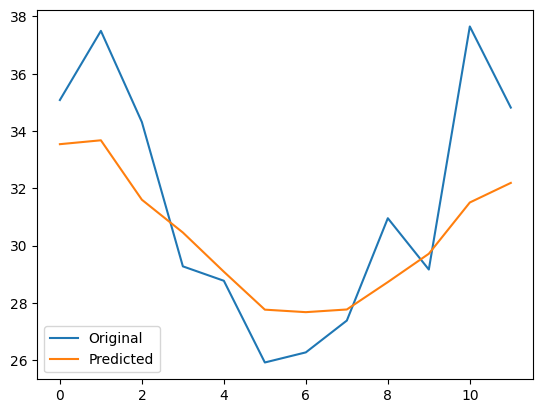

In [203]:
orig_y_eval = y_test*(_max-_min) + _min
orig_y_hat = y_result*(_max-_min) + _min
mae_error = mean_absolute_error(orig_y_eval, orig_y_hat)
mse_error = mean_squared_error(orig_y_eval, orig_y_hat)

plt.plot(orig_y_eval)
plt.plot(orig_y_hat)
plt.legend(['Original','Predicted'])

print(f'Erro MSE = {round(mse_error,3)} \nErro MAE = {round(mae_error,3)}')

##### **3.5.2.	Resposta**
**NUMÉRICA - MULTI-STEP - SIGMOID - 20 NEURÔNIOS NA CAMADA ESCONDIDA**

**Rodada 1:**

Erro MSE = **8.48** (°C)²

Erro MAE = **2.19** °C

**Rodada 2:**

Erro MSE = **8.52** (°C)²

Erro MAE = **2.20** °C

**Rodada 3:**

Erro MSE = **8.56** (°C)²

Erro MAE = **2.21** °C

**BINÁRIA - MULTI-STEP - SIGMOID - 20 NEURÔNIOS NA CAMADA ESCONDIDA**

**Rodada 1:**

Erro MSE = **6.77** (°C)²

Erro MAE = **2.06** °C

**Rodada 2:**

Erro MSE = **7.31** (°C)²

Erro MAE = **2.28** °C

**Rodada 3:**

Erro MSE = **7.29** (°C)²

Erro MAE = **2.26** °C

Comparando os resultados entre a análise considerando a classificação da variável exógena como 'numérica' ou 'binária', para o erro MAE os resultados não apresentam diferenças.
Porém, comparando o erro MSE, os resultados da 'binária' foram inferiores. A função sigmoid é indica para problemas de classificação binária, a codificação, 0 ou 1, pode ser mais facilmente ajustada pela função de ativação sigmoid. Já, na classificação numérica, a presença de *outliers* pode ter um impacto maior no MSE.